In [16]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
from tqdm import tqdm
from scipy.spatial.distance import hamming,cosine
%matplotlib inline


In [9]:

def image_loader(image_path, image_size):
    image=cv2.imread(image_path)            #To read image and strore it in a  variable name Image
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)       #By default image has BGR sequence to show pixel info SO we'll change it to RGB
    image=cv2.resize(image,image_size,cv2.INTER_CUBIC)
    return image


In [14]:
def dataset_preprocessing(dataset_path, labels_file_path, image_size, image_paths_pickle):
    '''
    Loads images and labels from dataset folder.
    
    :param dataset_path: String, path to the train/test dataset folder
    :param labels_file_path: String, path to the .txt file where classes names are written
    :param image_size: tuple, single image size
    :param image_paths_pickle: String, name of a pickle file where all image paths will be saved
    '''
    
    with open(labels_file_path, 'r') as f:
        classes = f.read().split('\n')[:-1]
        
    
    images = []
    labels = []
    image_paths = []
    
    for image_name in os.listdir(dataset_path):
        try:
            image_path = os.path.join(dataset_path, image_name)
            images.append(image_loader(image_path, image_size))
            image_paths.append(image_path)
            for idx in range(len(classes)):
                if classes[idx] in image_name: #Example: 0_frog.png
                    labels.append(idx)
        except:
            pass
    
    with open(image_paths_pickle + ".pickle", 'wb') as f:
        pickle.dump(image_paths, f)
    
    assert len(images) == len(labels)
    return np.array(images), np.array(labels)

In [15]:
images,labels=dataset_preprocessing("dataset/train/",'dataset/labels.txt',(32,32),"train_images_pickle")


In [13]:
images.shape
len(labels)

0

In [9]:
def cosine_distance(training_set_vectors,query_vector,top_n=50):
    #Vector of image is numpy Matrix
    #top_n=50 is number of closest image to return 
    
    distances=[]
    
    for i in range(len(training_set_vectors)):
        distances.append(cosine(training_set_vectors[i],query_vector[0]))   #After comprison between 2 img
                                                                        #which satisfy cosine cond^n are added to disatnces
    
    
    return np.argsort(distances)[:top_n]


In [10]:
def hamming_distance(training_set_vectors,query_vector,top_n=50):
    for i in range(len(training_set_vectors)):
        distances.append(cosine(training_set_vectors[i],query_vector[0]))
    
    
    return np.argsort(distances)[:top_n]

In [16]:
def sparse_accuracy(true_labels,predicted_labels):
    assert len(true_labels)==len(predicted_labels)
    correct=0
    
    for i in range(len(true_labels)):
        if np.argmax(predicted_labels[i])==true_labels[i]:
            correct+=1
    
    return correct / len(true_labels)

In [17]:
def model_inputs(image_size):
    inputs=tf.placeholder(dtype=tf.float32,shape=[None,image_size[0],image_size[1],3],name='images')
    targets=tf.placeholder(dtype=tf.int32,shape=[None,],name='targets')
    dropout_prob=tf.placeholder(dtype=tf.float32,name='dropout_prob')
    
    return inputs,targets,dropout_prob


In [18]:
def conv_block(inputs, 
               number_of_filters, 
               kernel_size, 
               strides=(1, 1), 
               padding='SAME', 
               activation=tf.nn.relu, 
               max_pool=True, 
               batch_norm=True):
    
    '''
    Defines convolutional block layer.
    
    :param inputs: data from a previous layer
    :param number_of_filters: integer, number of conv filters
    :param kernel_size: tuple, size of conv layer kernel
    :param padding: string, type of padding technique: SAME or VALID
    :param activation: tf.object, activation function used on the layer
    :param max_pool: boolean, if true the conv block will use max_pool
    :param batch_norm: boolean, if true the conv block will use batch normalization
    '''
    
    conv_features = layer = tf.layers.conv2d(inputs=inputs, 
                                             filters=number_of_filters, 
                                             kernel_size=kernel_size, 
                                             strides=strides, 
                                             padding=padding, 
                                             activation=activation)
    
    if max_pool:
        layer = tf.layers.max_pooling2d(layer, 
                                        pool_size=(2, 2), 
                                        strides=(2, 2),
                                        padding='SAME')
        
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
    return layer, conv_features

    

In [19]:
def dense_block(inputs, 
                units, 
                activation=tf.nn.relu, 
                dropout_rate=None, 
                batch_norm=True):
    
    '''
    Defines dense block layer.
    
    :param inputs: data from a previous layer
    :param units: integer, number of neurons/units for a dense layer
    :param activation: tf.object, activation function used on the layer
    :param dropout_rate: dropout rate used in this dense block
    :param batch_norm: boolean, if true the conv block will use batch normalization
    '''
    
    dense_features = layer = tf.layers.dense(inputs, 
                                             units=units, 
                                             activation=activation)
    
    if dropout_rate is not None:
        layer = tf.layers.dropout(layer, rate=dropout_rate)
    
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
    return layer, dense_features

In [20]:
def opt_loss(logits, 
             targets, 
             learning_rate):
    
    '''
    Defines model's optimizer and loss functions.
    
    :param logits: pre-activated model outputs
    :param targets: true labels for each input sample
    :param learning_rate: learning_rate
    '''
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return loss, optimizer

In [21]:
class ImageSearchModel(object):
    
    def __init__(self, 
                 learning_rate, 
                 image_size, 
                 number_of_classes=10):
        
        '''
        Defines CNN model.
        
        :param learning_rate: learning_rate
        :param image_size: tuple, (height, width) of an image
        :param number_of_classes: integer, number of classes in a dataset.
        '''
        
        tf.reset_default_graph()
        
        #model inputs
        self.inputs, self.targets, self.dropout_rate = model_inputs(image_size)
        
        normalized_images = tf.layers.batch_normalization(self.inputs)
        
        #conv_1 block
        conv_block_1, self.conv_1_features = conv_block(inputs=normalized_images, 
                                                        number_of_filters=64, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
 
        #conv_2 block
        conv_block_2, self.conv_2_features = conv_block(inputs=conv_block_1, 
                                                        number_of_filters=128, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True,  batch_norm=True)
        
        #conv_3 block
        conv_block_3, self.conv_3_features = conv_block(inputs=conv_block_2, 
                                                        number_of_filters=256, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #conv_4 block
        conv_block_4, self.conv_4_features = conv_block(inputs=conv_block_3, 
                                                        number_of_filters=512, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #flattening
        flat_layer = tf.layers.flatten(conv_block_4)
        
        #1st dense block
        dense_block_1, dense_1_features = dense_block(inputs=flat_layer, 
                                                       units=128, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #2nd dense block
        dense_block_2, self.dense_2_features = dense_block(inputs=dense_block_1, 
                                                       units=256, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #3rd dense block
        dense_block_3, self.dense_3_features = dense_block(inputs=dense_block_2, 
                                                       units=512, activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #4th dense block
        dense_block_4, self.dense_4_features = dense_block(inputs=dense_block_3, 
                                                       units=1024, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #output layer
        logits = tf.layers.dense(inputs=dense_block_4, 
                                 units=number_of_classes, 
                                 activation=None)
        
        self.predictions = tf.nn.softmax(logits)
        
        self.loss, self.optimizer = opt_loss(logits=logits, 
                                             targets=self.targets, 
                                             learning_rate=learning_rate)

In [22]:
def train(model, 
          epochs,
          drop_rate,
          batch_size, 
          data, 
          save_dir, 
          saver_delta=0.15):
    
    '''
    The core training function, use this function to train a model.
    
    :param model: CNN model
    :param epochs: integer, number of epochs
    :param drop_rate: float, dropout_rate
    :param batch_size: integer, number of samples to put through the model at once
    :param data: tuple, train-test data Example(X_train, y_train, X_test, y_test)
    :param save_dir: string, path to a folder where model checkpoints will be saved
    :param saver_delta: float, used to prevent overfitted model to be saved
    '''
    
    X_train, y_train, X_test, y_test = data
    
    #start session
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    #define saver
    saver = tf.train.Saver()
    
    best_test_accuracy = 0.0
    #start training loop
    for epoch in range(epochs):
        
        train_accuracy = []
        train_loss = []
        
        for ii in tqdm(range(len(X_train) // batch_size)):
            start_id = ii*batch_size
            end_id = start_id + batch_size
            
            X_batch = X_train[start_id:end_id]
            y_batch = y_train[start_id:end_id]
            
            feed_dict = {model.inputs:X_batch, 
                         model.targets:y_batch, 
                         model.dropout_rate:drop_rate}
            
            _, t_loss, preds_t = session.run([model.optimizer, model.loss, model.predictions], feed_dict=feed_dict)
            
            train_accuracy.append(sparse_accuracy(y_batch, preds_t))
            train_loss.append(t_loss)
            
        print("Epoch: {}/{}".format(epoch, epochs),  
              " | Training accuracy: {}".format(np.mean(train_accuracy)), 
              " | Training loss: {}".format(np.mean(train_loss)) )
        
        test_accuracy = []
        
        for ii in tqdm(range(len(X_test) // batch_size)):
            start_id = ii*batch_size
            end_id = start_id + batch_size
            
            X_batch = X_test[start_id:end_id]
            y_batch = y_test[start_id:end_id]
            
            feed_dict = {model.inputs:X_batch, 
                         model.dropout_rate:0.0}
            
            preds_test = session.run(model.predictions, feed_dict=feed_dict)
            test_accuracy.append(sparse_accuracy(y_batch, preds_test))
            
        print("Test accuracy: {}".format(np.mean(test_accuracy)))
        
        #saving the model
        if np.mean(train_accuracy) > np.mean(test_accuracy): #to prevent underfitting
            if np.abs(np.mean(train_accuracy) - np.mean(test_accuracy)) <= saver_delta: #to prevent overfit
                if np.mean(test_accuracy) >= best_test_accuracy:
                    best_test_accuracy = np.mean(test_accuracy)
                    saver.save(session, "{}/model_epoch_{}.ckpt".format(save_dir, epoch))
                    
    session.close()









In [23]:
epochs = 20
batch_size = 128
learning_rate = 0.001
dropout_probs = 0.6
image_size = (32, 32)





In [24]:

X_train, y_train = dataset_preprocessing('dataset/train/', 'dataset/labels.txt', image_size=image_size, image_paths_pickle="train_images_pickle")

In [25]:
X_train.shape

(0,)

In [18]:
X_test, y_test = dataset_preprocessing('dataset/test/', 'dataset/labels.txt', image_size=image_size, image_paths_pickle="test_images_pickle")

In [19]:
X_test.shape

(10000, 32, 32, 3)

In [20]:
model = ImageSearchModel(learning_rate, image_size)


Instructions for updating:
Use keras.layers.batch_normalization instead.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use keras.layers.conv2d instead.


Instructions for updating:
Use keras.layers.max_pooling2d instead.


Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use keras.layers.dropout instead.


In [21]:
data = (X_train, y_train, X_test, y_test)

In [22]:
train(model, epochs, dropout_probs, batch_size, data, 'saver')

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:06<04:59,  6.97s/it]

  5%|▍         | 2/44 [00:10<04:04,  5.81s/it]

  7%|▋         | 3/44 [00:13<03:28,  5.08s/it]

  9%|▉         | 4/44 [00:16<03:01,  4.54s/it]

 11%|█▏        | 5/44 [00:19<02:42,  4.16s/it]

 14%|█▎        | 6/44 [00:23<02:30,  3.95s/it]

 16%|█▌        | 7/44 [00:26<02:18,  3.75s/it]

 18%|█▊        | 8/44 [00:30<02:10,  3.61s/it]

 20%|██        | 9/44 [00:33<02:01,  3.48s/it]

 23%|██▎       | 10/44 [00:36<01:54,  3.36s/it]

 25%|██▌       | 11/44 [00:39<01:48,  3.29s/it]

 27%|██▋       | 12/44 [00:42<01:45,  3.29s/it]

 30%|██▉       | 13/44 [00:46<01:44,  3.38s/it]

 32%|███▏      | 14/44 [00:49<01:42,  3.41s/it]

 34%|███▍      | 15/44 [00:53<01:39,  3.45s/it]

 36%|███▋      | 16/44 [00:56<01:37,  3.50s/it]

 39%|███▊      | 17/44 [01:00<01:34,  3.48s/it]

 41%|████      | 18/44 [01:03<01:29,  3.46s/it]

 43%|████▎     | 19/44 [01:07<01:25,  3.43s/it]

 45%|████▌     | 20/44 [01:10<01:22,  3.43s/it]

 48%|████▊     | 21/44 [01:13<01:17,  3.38s/it]

 50%|█████     | 22/44 [01:17<01:13,  3.34s/it]

 52%|█████▏    | 23/44 [01:20<01:11,  3.40s/it]

 55%|█████▍    | 24/44 [01:24<01:08,  3.42s/it]

 57%|█████▋    | 25/44 [01:27<01:03,  3.36s/it]

 59%|█████▉    | 26/44 [01:30<01:00,  3.38s/it]

 61%|██████▏   | 27/44 [01:34<00:57,  3.39s/it]

 64%|██████▎   | 28/44 [01:37<00:53,  3.36s/it]

 66%|██████▌   | 29/44 [01:40<00:49,  3.33s/it]

 68%|██████▊   | 30/44 [01:43<00:46,  3.30s/it]

 70%|███████   | 31/44 [01:47<00:42,  3.26s/it]

 73%|███████▎  | 32/44 [01:50<00:40,  3.35s/it]

 75%|███████▌  | 33/44 [01:54<00:37,  3.37s/it]

 77%|███████▋  | 34/44 [01:57<00:33,  3.37s/it]

 80%|███████▉  | 35/44 [02:01<00:31,  3.47s/it]

 82%|████████▏ | 36/44 [02:04<00:27,  3.49s/it]

 84%|████████▍ | 37/44 [02:07<00:22,  3.28s/it]

 86%|████████▋ | 38/44 [02:10<00:18,  3.12s/it]

 89%|████████▊ | 39/44 [02:12<00:15,  3.00s/it]

 91%|█████████ | 40/44 [02:15<00:11,  2.88s/it]

 93%|█████████▎| 41/44 [02:18<00:08,  2.81s/it]

 95%|█████████▌| 42/44 [02:20<00:05,  2.77s/it]

 98%|█████████▊| 43/44 [02:23<00:02,  2.74s/it]

100%|██████████| 44/44 [02:26<00:00,  2.69s/it]

Epoch: 0/20

 | Training accuracy: 0.16548295454545456

 | Training loss: 3.6069467067718506

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:03,  1.89it/s]

 29%|██▊       | 2/7 [00:00<00:02,  2.09it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.17it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.30it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.39it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.36it/s]

100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

Test accuracy: 0.2734375

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:58,  2.76s/it]

  5%|▍         | 2/44 [00:05<01:53,  2.71s/it]

  7%|▋         | 3/44 [00:07<01:49,  2.67s/it]

  9%|▉         | 4/44 [00:10<01:46,  2.66s/it]

 11%|█▏        | 5/44 [00:13<01:43,  2.66s/it]

 14%|█▎        | 6/44 [00:15<01:40,  2.65s/it]

 16%|█▌        | 7/44 [00:18<01:37,  2.63s/it]

 18%|█▊        | 8/44 [00:21<01:35,  2.64s/it]

 20%|██        | 9/44 [00:23<01:32,  2.64s/it]

 23%|██▎       | 10/44 [00:26<01:29,  2.63s/it]

 25%|██▌       | 11/44 [00:29<01:27,  2.65s/it]

 27%|██▋       | 12/44 [00:32<01:28,  2.77s/it]

 30%|██▉       | 13/44 [00:35<01:27,  2.82s/it]

 32%|███▏      | 14/44 [00:37<01:23,  2.78s/it]

 34%|███▍      | 15/44 [00:40<01:18,  2.72s/it]

 36%|███▋      | 16/44 [00:43<01:16,  2.72s/it]

 39%|███▊      | 17/44 [00:45<01:12,  2.70s/it]

 41%|████      | 18/44 [00:48<01:09,  2.67s/it]

 43%|████▎     | 19/44 [00:50<01:06,  2.67s/it]

 45%|████▌     | 20/44 [00:53<01:03,  2.66s/it]

 48%|████▊     | 21/44 [00:56<01:04,  2.82s/it]

 50%|█████     | 22/44 [00:59<01:04,  2.94s/it]

 52%|█████▏    | 23/44 [01:03<01:04,  3.08s/it]

 55%|█████▍    | 24/44 [01:06<01:04,  3.21s/it]

 57%|█████▋    | 25/44 [01:10<01:02,  3.27s/it]

 59%|█████▉    | 26/44 [01:13<01:00,  3.35s/it]

 61%|██████▏   | 27/44 [01:16<00:54,  3.21s/it]

 64%|██████▎   | 28/44 [01:19<00:49,  3.07s/it]

 66%|██████▌   | 29/44 [01:22<00:44,  2.95s/it]

 68%|██████▊   | 30/44 [01:24<00:39,  2.85s/it]

 70%|███████   | 31/44 [01:27<00:36,  2.78s/it]

 73%|███████▎  | 32/44 [01:30<00:32,  2.73s/it]

 75%|███████▌  | 33/44 [01:32<00:29,  2.69s/it]

 77%|███████▋  | 34/44 [01:35<00:26,  2.67s/it]

 80%|███████▉  | 35/44 [01:37<00:23,  2.65s/it]

 82%|████████▏ | 36/44 [01:40<00:21,  2.63s/it]

 84%|████████▍ | 37/44 [01:43<00:18,  2.65s/it]

 86%|████████▋ | 38/44 [01:45<00:15,  2.66s/it]

 89%|████████▊ | 39/44 [01:48<00:13,  2.66s/it]

 91%|█████████ | 40/44 [01:51<00:10,  2.65s/it]

 93%|█████████▎| 41/44 [01:53<00:07,  2.63s/it]

 95%|█████████▌| 42/44 [01:56<00:05,  2.64s/it]

 98%|█████████▊| 43/44 [01:58<00:02,  2.63s/it]

100%|██████████| 44/44 [02:01<00:00,  2.61s/it]

Epoch: 1/20

 | Training accuracy: 0.3006036931818182

 | Training loss: 1.8617995977401733

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.54it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.63it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.69it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.73it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.77it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.80it/s]

100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

Test accuracy: 0.32589285714285715

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:52,  2.62s/it]

  5%|▍         | 2/44 [00:05<01:50,  2.62s/it]

  7%|▋         | 3/44 [00:07<01:47,  2.63s/it]

  9%|▉         | 4/44 [00:10<01:44,  2.61s/it]

 11%|█▏        | 5/44 [00:13<01:41,  2.60s/it]

 14%|█▎        | 6/44 [00:15<01:39,  2.61s/it]

 16%|█▌        | 7/44 [00:18<01:37,  2.64s/it]

 18%|█▊        | 8/44 [00:20<01:34,  2.62s/it]

 20%|██        | 9/44 [00:23<01:31,  2.61s/it]

 23%|██▎       | 10/44 [00:26<01:29,  2.62s/it]

 25%|██▌       | 11/44 [00:28<01:26,  2.61s/it]

 27%|██▋       | 12/44 [00:31<01:23,  2.61s/it]

 30%|██▉       | 13/44 [00:33<01:20,  2.60s/it]

 32%|███▏      | 14/44 [00:36<01:18,  2.60s/it]

 34%|███▍      | 15/44 [00:39<01:15,  2.60s/it]

 36%|███▋      | 16/44 [00:42<01:14,  2.68s/it]

 39%|███▊      | 17/44 [00:45<01:18,  2.90s/it]

 41%|████      | 18/44 [00:48<01:17,  3.00s/it]

 43%|████▎     | 19/44 [00:52<01:20,  3.20s/it]

 45%|████▌     | 20/44 [00:56<01:24,  3.51s/it]

 48%|████▊     | 21/44 [01:02<01:38,  4.27s/it]

 50%|█████     | 22/44 [01:09<01:48,  4.95s/it]

 52%|█████▏    | 23/44 [01:12<01:34,  4.52s/it]

 55%|█████▍    | 24/44 [01:16<01:23,  4.17s/it]

 57%|█████▋    | 25/44 [01:19<01:15,  3.96s/it]

 59%|█████▉    | 26/44 [01:22<01:08,  3.82s/it]

 61%|██████▏   | 27/44 [01:26<01:03,  3.73s/it]

 64%|██████▎   | 28/44 [01:30<00:58,  3.68s/it]

 66%|██████▌   | 29/44 [01:33<00:53,  3.58s/it]

 68%|██████▊   | 30/44 [01:36<00:49,  3.56s/it]

 70%|███████   | 31/44 [01:40<00:46,  3.54s/it]

 73%|███████▎  | 32/44 [01:43<00:42,  3.55s/it]

 75%|███████▌  | 33/44 [01:47<00:38,  3.54s/it]

 77%|███████▋  | 34/44 [01:51<00:35,  3.53s/it]

 80%|███████▉  | 35/44 [01:54<00:31,  3.53s/it]

 82%|████████▏ | 36/44 [01:58<00:28,  3.53s/it]

 84%|████████▍ | 37/44 [02:01<00:24,  3.45s/it]

 86%|████████▋ | 38/44 [02:04<00:19,  3.26s/it]

 89%|████████▊ | 39/44 [02:07<00:15,  3.14s/it]

 91%|█████████ | 40/44 [02:09<00:12,  3.07s/it]

 93%|█████████▎| 41/44 [02:12<00:08,  2.96s/it]

 95%|█████████▌| 42/44 [02:15<00:05,  2.88s/it]

 98%|█████████▊| 43/44 [02:18<00:02,  2.82s/it]

100%|██████████| 44/44 [02:20<00:00,  2.76s/it]

Epoch: 2/20

 | Training accuracy: 0.3819247159090909

 | Training loss: 1.6609386205673218

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.47it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.54it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.60it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.63it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.62it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.64it/s]

100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

Test accuracy: 0.36495535714285715

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:59,  2.77s/it]

  5%|▍         | 2/44 [00:05<01:55,  2.75s/it]

  7%|▋         | 3/44 [00:08<01:50,  2.70s/it]

  9%|▉         | 4/44 [00:11<01:51,  2.78s/it]

 11%|█▏        | 5/44 [00:13<01:48,  2.79s/it]

 14%|█▎        | 6/44 [00:16<01:44,  2.76s/it]

 16%|█▌        | 7/44 [00:19<01:41,  2.75s/it]

 18%|█▊        | 8/44 [00:21<01:38,  2.74s/it]

 20%|██        | 9/44 [00:24<01:37,  2.77s/it]

 23%|██▎       | 10/44 [00:27<01:36,  2.85s/it]

 25%|██▌       | 11/44 [00:30<01:34,  2.86s/it]

 27%|██▋       | 12/44 [00:33<01:31,  2.86s/it]

 30%|██▉       | 13/44 [00:36<01:29,  2.88s/it]

 32%|███▏      | 14/44 [00:39<01:25,  2.84s/it]

 34%|███▍      | 15/44 [00:42<01:21,  2.83s/it]

 36%|███▋      | 16/44 [00:44<01:17,  2.78s/it]

 39%|███▊      | 17/44 [00:47<01:14,  2.75s/it]

 41%|████      | 18/44 [00:50<01:10,  2.71s/it]

 43%|████▎     | 19/44 [00:52<01:07,  2.69s/it]

 45%|████▌     | 20/44 [00:55<01:04,  2.69s/it]

 48%|████▊     | 21/44 [00:57<01:01,  2.67s/it]

 50%|█████     | 22/44 [01:00<00:58,  2.66s/it]

 52%|█████▏    | 23/44 [01:03<00:56,  2.68s/it]

 55%|█████▍    | 24/44 [01:06<00:54,  2.70s/it]

 57%|█████▋    | 25/44 [01:08<00:51,  2.71s/it]

 59%|█████▉    | 26/44 [01:11<00:49,  2.73s/it]

 61%|██████▏   | 27/44 [01:14<00:46,  2.73s/it]

 64%|██████▎   | 28/44 [01:17<00:43,  2.74s/it]

 66%|██████▌   | 29/44 [01:19<00:41,  2.74s/it]

 68%|██████▊   | 30/44 [01:22<00:38,  2.73s/it]

 70%|███████   | 31/44 [01:25<00:35,  2.71s/it]

 73%|███████▎  | 32/44 [01:27<00:32,  2.71s/it]

 75%|███████▌  | 33/44 [01:30<00:29,  2.71s/it]

 77%|███████▋  | 34/44 [01:33<00:27,  2.70s/it]

 80%|███████▉  | 35/44 [01:36<00:24,  2.69s/it]

 82%|████████▏ | 36/44 [01:38<00:21,  2.69s/it]

 84%|████████▍ | 37/44 [01:41<00:19,  2.72s/it]

 86%|████████▋ | 38/44 [01:44<00:16,  2.79s/it]

 89%|████████▊ | 39/44 [01:47<00:13,  2.80s/it]

 91%|█████████ | 40/44 [01:50<00:11,  2.79s/it]

 93%|█████████▎| 41/44 [01:52<00:08,  2.81s/it]

 95%|█████████▌| 42/44 [01:55<00:05,  2.83s/it]

 98%|█████████▊| 43/44 [01:58<00:02,  2.84s/it]

100%|██████████| 44/44 [02:01<00:00,  2.80s/it]

Epoch: 3/20

 | Training accuracy: 0.4289772727272727

 | Training loss: 1.5325801372528076

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.34it/s]

 29%|██▊       | 2/7 [00:00<00:02,  2.44it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.50it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.58it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.59it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.62it/s]

100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

Test accuracy: 0.4497767857142857

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:54,  2.65s/it]

  5%|▍         | 2/44 [00:05<01:52,  2.67s/it]

  7%|▋         | 3/44 [00:07<01:49,  2.66s/it]

  9%|▉         | 4/44 [00:10<01:45,  2.64s/it]

 11%|█▏        | 5/44 [00:13<01:42,  2.63s/it]

 14%|█▎        | 6/44 [00:15<01:40,  2.64s/it]

 16%|█▌        | 7/44 [00:18<01:37,  2.64s/it]

 18%|█▊        | 8/44 [00:21<01:34,  2.63s/it]

 20%|██        | 9/44 [00:23<01:32,  2.63s/it]

 23%|██▎       | 10/44 [00:26<01:28,  2.62s/it]

 25%|██▌       | 11/44 [00:28<01:26,  2.63s/it]

 27%|██▋       | 12/44 [00:32<01:28,  2.78s/it]

 30%|██▉       | 13/44 [00:34<01:26,  2.78s/it]

 32%|███▏      | 14/44 [00:37<01:23,  2.78s/it]

 34%|███▍      | 15/44 [00:40<01:19,  2.73s/it]

 36%|███▋      | 16/44 [00:42<01:15,  2.70s/it]

 39%|███▊      | 17/44 [00:45<01:13,  2.70s/it]

 41%|████      | 18/44 [00:48<01:10,  2.70s/it]

 43%|████▎     | 19/44 [00:50<01:06,  2.68s/it]

 45%|████▌     | 20/44 [00:53<01:03,  2.65s/it]

 48%|████▊     | 21/44 [00:56<01:00,  2.63s/it]

 50%|█████     | 22/44 [00:58<00:57,  2.63s/it]

 52%|█████▏    | 23/44 [01:01<00:55,  2.65s/it]

 55%|█████▍    | 24/44 [01:04<00:52,  2.64s/it]

 57%|█████▋    | 25/44 [01:06<00:50,  2.66s/it]

 59%|█████▉    | 26/44 [01:09<00:49,  2.73s/it]

 61%|██████▏   | 27/44 [01:12<00:47,  2.81s/it]

 64%|██████▎   | 28/44 [01:15<00:44,  2.79s/it]

 66%|██████▌   | 29/44 [01:18<00:41,  2.78s/it]

 68%|██████▊   | 30/44 [01:20<00:38,  2.75s/it]

 70%|███████   | 31/44 [01:23<00:35,  2.72s/it]

 73%|███████▎  | 32/44 [01:26<00:32,  2.71s/it]

 75%|███████▌  | 33/44 [01:29<00:31,  2.87s/it]

 77%|███████▋  | 34/44 [01:32<00:29,  2.96s/it]

 80%|███████▉  | 35/44 [01:35<00:26,  2.98s/it]

 82%|████████▏ | 36/44 [01:38<00:24,  3.10s/it]

 84%|████████▍ | 37/44 [01:42<00:22,  3.23s/it]

 86%|████████▋ | 38/44 [01:46<00:19,  3.32s/it]

 89%|████████▊ | 39/44 [01:49<00:16,  3.38s/it]

 91%|█████████ | 40/44 [01:53<00:14,  3.50s/it]

 93%|█████████▎| 41/44 [01:56<00:09,  3.29s/it]

 95%|█████████▌| 42/44 [01:58<00:06,  3.14s/it]

 98%|█████████▊| 43/44 [02:01<00:03,  3.01s/it]

100%|██████████| 44/44 [02:04<00:00,  2.96s/it]

Epoch: 4/20

 | Training accuracy: 0.4650213068181818

 | Training loss: 1.4471145868301392

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.31it/s]

 29%|██▊       | 2/7 [00:00<00:02,  2.41it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.47it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.53it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.51it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.50it/s]

100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

Test accuracy: 0.4732142857142857

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:03<02:29,  3.48s/it]

  5%|▍         | 2/44 [00:06<02:23,  3.41s/it]

  7%|▋         | 3/44 [00:09<02:17,  3.35s/it]

  9%|▉         | 4/44 [00:13<02:11,  3.29s/it]

 11%|█▏        | 5/44 [00:15<02:01,  3.12s/it]

 14%|█▎        | 6/44 [00:18<01:53,  2.99s/it]

 16%|█▌        | 7/44 [00:21<01:46,  2.89s/it]

 18%|█▊        | 8/44 [00:23<01:41,  2.81s/it]

 20%|██        | 9/44 [00:26<01:35,  2.74s/it]

 23%|██▎       | 10/44 [00:29<01:32,  2.72s/it]

 25%|██▌       | 11/44 [00:31<01:29,  2.72s/it]

 27%|██▋       | 12/44 [00:34<01:27,  2.72s/it]

 30%|██▉       | 13/44 [00:37<01:24,  2.72s/it]

 32%|███▏      | 14/44 [00:39<01:21,  2.73s/it]

 34%|███▍      | 15/44 [00:42<01:18,  2.72s/it]

 36%|███▋      | 16/44 [00:45<01:16,  2.72s/it]

 39%|███▊      | 17/44 [00:48<01:13,  2.73s/it]

 41%|████      | 18/44 [00:50<01:11,  2.74s/it]

 43%|████▎     | 19/44 [00:53<01:08,  2.74s/it]

 45%|████▌     | 20/44 [00:56<01:05,  2.73s/it]

 48%|████▊     | 21/44 [00:59<01:02,  2.74s/it]

 50%|█████     | 22/44 [01:01<01:00,  2.73s/it]

 52%|█████▏    | 23/44 [01:04<00:57,  2.72s/it]

 55%|█████▍    | 24/44 [01:07<00:54,  2.73s/it]

 57%|█████▋    | 25/44 [01:09<00:51,  2.72s/it]

 59%|█████▉    | 26/44 [01:12<00:48,  2.71s/it]

 61%|██████▏   | 27/44 [01:15<00:45,  2.70s/it]

 64%|██████▎   | 28/44 [01:18<00:43,  2.71s/it]

 66%|██████▌   | 29/44 [01:20<00:40,  2.68s/it]

 68%|██████▊   | 30/44 [01:23<00:37,  2.67s/it]

 70%|███████   | 31/44 [01:26<00:35,  2.72s/it]

 73%|███████▎  | 32/44 [01:28<00:32,  2.74s/it]

 75%|███████▌  | 33/44 [01:31<00:30,  2.78s/it]

 77%|███████▋  | 34/44 [01:34<00:27,  2.78s/it]

 80%|███████▉  | 35/44 [01:37<00:24,  2.77s/it]

 82%|████████▏ | 36/44 [01:40<00:22,  2.82s/it]

 84%|████████▍ | 37/44 [01:43<00:19,  2.83s/it]

 86%|████████▋ | 38/44 [01:45<00:17,  2.84s/it]

 89%|████████▊ | 39/44 [01:48<00:13,  2.79s/it]

 91%|█████████ | 40/44 [01:51<00:11,  2.77s/it]

 93%|█████████▎| 41/44 [01:54<00:08,  2.80s/it]

 95%|█████████▌| 42/44 [01:56<00:05,  2.77s/it]

 98%|█████████▊| 43/44 [01:59<00:02,  2.75s/it]

100%|██████████| 44/44 [02:02<00:00,  2.75s/it]

Epoch: 5/20

 | Training accuracy: 0.5324928977272727

 | Training loss: 1.2796506881713867

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.41it/s]

 29%|██▊       | 2/7 [00:00<00:02,  2.48it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.55it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.63it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.70it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.75it/s]

100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

Test accuracy: 0.42410714285714285

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<02:03,  2.87s/it]

  5%|▍         | 2/44 [00:05<01:59,  2.85s/it]

  7%|▋         | 3/44 [00:08<01:55,  2.82s/it]

  9%|▉         | 4/44 [00:11<01:59,  2.98s/it]

 11%|█▏        | 5/44 [00:15<02:04,  3.18s/it]

 14%|█▎        | 6/44 [00:18<02:05,  3.30s/it]

 16%|█▌        | 7/44 [00:22<02:04,  3.37s/it]

 18%|█▊        | 8/44 [00:26<02:03,  3.43s/it]

 20%|██        | 9/44 [00:29<02:01,  3.47s/it]

 23%|██▎       | 10/44 [00:32<01:55,  3.40s/it]

 25%|██▌       | 11/44 [00:35<01:46,  3.24s/it]

 27%|██▋       | 12/44 [00:38<01:39,  3.11s/it]

 30%|██▉       | 13/44 [00:41<01:33,  3.02s/it]

 32%|███▏      | 14/44 [00:44<01:30,  3.01s/it]

 34%|███▍      | 15/44 [00:47<01:25,  2.95s/it]

 36%|███▋      | 16/44 [00:49<01:21,  2.91s/it]

 39%|███▊      | 17/44 [00:52<01:17,  2.88s/it]

 41%|████      | 18/44 [00:55<01:15,  2.92s/it]

 43%|████▎     | 19/44 [00:58<01:14,  2.99s/it]

 45%|████▌     | 20/44 [01:01<01:10,  2.95s/it]

 48%|████▊     | 21/44 [01:04<01:07,  2.92s/it]

 50%|█████     | 22/44 [01:07<01:03,  2.87s/it]

 52%|█████▏    | 23/44 [01:10<00:58,  2.81s/it]

 55%|█████▍    | 24/44 [01:12<00:54,  2.74s/it]

 57%|█████▋    | 25/44 [01:15<00:51,  2.73s/it]

 59%|█████▉    | 26/44 [01:18<00:48,  2.72s/it]

 61%|██████▏   | 27/44 [01:20<00:45,  2.69s/it]

 64%|██████▎   | 28/44 [01:23<00:42,  2.67s/it]

 66%|██████▌   | 29/44 [01:25<00:39,  2.66s/it]

 68%|██████▊   | 30/44 [01:28<00:36,  2.64s/it]

 70%|███████   | 31/44 [01:31<00:34,  2.63s/it]

 73%|███████▎  | 32/44 [01:33<00:31,  2.63s/it]

 75%|███████▌  | 33/44 [01:36<00:28,  2.63s/it]

 77%|███████▋  | 34/44 [01:39<00:26,  2.66s/it]

 80%|███████▉  | 35/44 [01:41<00:23,  2.65s/it]

 82%|████████▏ | 36/44 [01:44<00:20,  2.62s/it]

 84%|████████▍ | 37/44 [01:46<00:18,  2.62s/it]

 86%|████████▋ | 38/44 [01:49<00:15,  2.62s/it]

 89%|████████▊ | 39/44 [01:52<00:13,  2.62s/it]

 91%|█████████ | 40/44 [01:54<00:10,  2.62s/it]

 93%|█████████▎| 41/44 [01:57<00:07,  2.62s/it]

 95%|█████████▌| 42/44 [02:00<00:05,  2.61s/it]

 98%|█████████▊| 43/44 [02:02<00:02,  2.60s/it]

100%|██████████| 44/44 [02:05<00:00,  2.61s/it]

Epoch: 6/20

 | Training accuracy: 0.580078125

 | Training loss: 1.1343203783035278

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.46it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.51it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.56it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.61it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.62it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.64it/s]

100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

Test accuracy: 0.4564732142857143

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:58,  2.75s/it]

  5%|▍         | 2/44 [00:05<01:53,  2.71s/it]

  7%|▋         | 3/44 [00:07<01:49,  2.68s/it]

  9%|▉         | 4/44 [00:10<01:46,  2.66s/it]

 11%|█▏        | 5/44 [00:13<01:44,  2.67s/it]

 14%|█▎        | 6/44 [00:15<01:40,  2.66s/it]

 16%|█▌        | 7/44 [00:18<01:37,  2.63s/it]

 18%|█▊        | 8/44 [00:21<01:36,  2.68s/it]

 20%|██        | 9/44 [00:24<01:34,  2.71s/it]

 23%|██▎       | 10/44 [00:26<01:31,  2.70s/it]

 25%|██▌       | 11/44 [00:29<01:28,  2.68s/it]

 27%|██▋       | 12/44 [00:32<01:25,  2.67s/it]

 30%|██▉       | 13/44 [00:34<01:21,  2.64s/it]

 32%|███▏      | 14/44 [00:37<01:18,  2.63s/it]

 34%|███▍      | 15/44 [00:39<01:15,  2.62s/it]

 36%|███▋      | 16/44 [00:42<01:13,  2.61s/it]

 39%|███▊      | 17/44 [00:44<01:10,  2.61s/it]

 41%|████      | 18/44 [00:47<01:07,  2.60s/it]

 43%|████▎     | 19/44 [00:50<01:08,  2.75s/it]

 45%|████▌     | 20/44 [00:54<01:10,  2.94s/it]

 48%|████▊     | 21/44 [00:57<01:08,  3.00s/it]

 50%|█████     | 22/44 [00:59<01:04,  2.93s/it]

 52%|█████▏    | 23/44 [01:03<01:05,  3.10s/it]

 55%|█████▍    | 24/44 [01:06<01:00,  3.02s/it]

 57%|█████▋    | 25/44 [01:09<00:57,  3.03s/it]

 59%|█████▉    | 26/44 [01:11<00:52,  2.91s/it]

 61%|██████▏   | 27/44 [01:14<00:48,  2.83s/it]

 64%|██████▎   | 28/44 [01:17<00:44,  2.77s/it]

 66%|██████▌   | 29/44 [01:19<00:40,  2.72s/it]

 68%|██████▊   | 30/44 [01:22<00:37,  2.69s/it]

 70%|███████   | 31/44 [01:25<00:34,  2.67s/it]

 73%|███████▎  | 32/44 [01:27<00:32,  2.68s/it]

 75%|███████▌  | 33/44 [01:30<00:29,  2.72s/it]

 77%|███████▋  | 34/44 [01:33<00:27,  2.77s/it]

 80%|███████▉  | 35/44 [01:36<00:24,  2.74s/it]

 82%|████████▏ | 36/44 [01:39<00:24,  3.05s/it]

 84%|████████▍ | 37/44 [01:43<00:22,  3.21s/it]

 86%|████████▋ | 38/44 [01:46<00:19,  3.20s/it]

 89%|████████▊ | 39/44 [01:50<00:16,  3.30s/it]

 91%|█████████ | 40/44 [01:54<00:13,  3.47s/it]

 93%|█████████▎| 41/44 [01:57<00:10,  3.47s/it]

 95%|█████████▌| 42/44 [02:01<00:06,  3.48s/it]

 98%|█████████▊| 43/44 [02:04<00:03,  3.50s/it]

100%|██████████| 44/44 [02:08<00:00,  3.51s/it]

Epoch: 7/20

 | Training accuracy: 0.6301491477272727

 | Training loss: 1.017735242843628

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:03,  1.89it/s]

 29%|██▊       | 2/7 [00:01<00:02,  1.96it/s]

 43%|████▎     | 3/7 [00:01<00:02,  1.98it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  1.99it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.06it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.09it/s]

100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

Test accuracy: 0.421875

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:03<02:32,  3.55s/it]

  5%|▍         | 2/44 [00:07<02:31,  3.61s/it]

  7%|▋         | 3/44 [00:10<02:25,  3.56s/it]

  9%|▉         | 4/44 [00:14<02:21,  3.54s/it]

 11%|█▏        | 5/44 [00:17<02:20,  3.60s/it]

 14%|█▎        | 6/44 [00:21<02:17,  3.61s/it]

 16%|█▌        | 7/44 [00:25<02:13,  3.60s/it]

 18%|█▊        | 8/44 [00:28<02:10,  3.61s/it]

 20%|██        | 9/44 [00:32<02:05,  3.58s/it]

 23%|██▎       | 10/44 [00:35<02:00,  3.56s/it]

 25%|██▌       | 11/44 [00:39<01:56,  3.55s/it]

 27%|██▋       | 12/44 [00:42<01:51,  3.50s/it]

 30%|██▉       | 13/44 [00:46<01:46,  3.44s/it]

 32%|███▏      | 14/44 [00:49<01:43,  3.46s/it]

 34%|███▍      | 15/44 [00:53<01:45,  3.63s/it]

 36%|███▋      | 16/44 [00:57<01:41,  3.62s/it]

 39%|███▊      | 17/44 [01:00<01:35,  3.53s/it]

 41%|████      | 18/44 [01:03<01:30,  3.49s/it]

 43%|████▎     | 19/44 [01:06<01:23,  3.32s/it]

 45%|████▌     | 20/44 [01:09<01:17,  3.21s/it]

 48%|████▊     | 21/44 [01:12<01:10,  3.07s/it]

 50%|█████     | 22/44 [01:15<01:05,  2.97s/it]

 52%|█████▏    | 23/44 [01:17<00:59,  2.85s/it]

 55%|█████▍    | 24/44 [01:20<00:55,  2.77s/it]

 57%|█████▋    | 25/44 [01:23<00:51,  2.74s/it]

 59%|█████▉    | 26/44 [01:25<00:48,  2.70s/it]

 61%|██████▏   | 27/44 [01:28<00:45,  2.68s/it]

 64%|██████▎   | 28/44 [01:30<00:42,  2.65s/it]

 66%|██████▌   | 29/44 [01:33<00:39,  2.64s/it]

 68%|██████▊   | 30/44 [01:36<00:36,  2.63s/it]

 70%|███████   | 31/44 [01:38<00:34,  2.62s/it]

 73%|███████▎  | 32/44 [01:41<00:31,  2.60s/it]

 75%|███████▌  | 33/44 [01:43<00:28,  2.59s/it]

 77%|███████▋  | 34/44 [01:46<00:25,  2.59s/it]

 80%|███████▉  | 35/44 [01:49<00:23,  2.59s/it]

 82%|████████▏ | 36/44 [01:51<00:20,  2.57s/it]

 84%|████████▍ | 37/44 [01:54<00:18,  2.58s/it]

 86%|████████▋ | 38/44 [01:56<00:15,  2.58s/it]

 89%|████████▊ | 39/44 [01:59<00:12,  2.58s/it]

 91%|█████████ | 40/44 [02:01<00:10,  2.58s/it]

 93%|█████████▎| 41/44 [02:04<00:07,  2.59s/it]

 95%|█████████▌| 42/44 [02:07<00:05,  2.60s/it]

 98%|█████████▊| 43/44 [02:09<00:02,  2.60s/it]

100%|██████████| 44/44 [02:12<00:00,  2.58s/it]

Epoch: 8/20

 | Training accuracy: 0.6448863636363636

 | Training loss: 0.9690885543823242

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.53it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.63it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.71it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.74it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.80it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.84it/s]

100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

Test accuracy: 0.4341517857142857

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:54,  2.67s/it]

  5%|▍         | 2/44 [00:05<01:50,  2.64s/it]

  7%|▋         | 3/44 [00:07<01:47,  2.62s/it]

  9%|▉         | 4/44 [00:10<01:44,  2.62s/it]

 11%|█▏        | 5/44 [00:13<01:41,  2.61s/it]

 14%|█▎        | 6/44 [00:15<01:39,  2.62s/it]

 16%|█▌        | 7/44 [00:18<01:37,  2.63s/it]

 18%|█▊        | 8/44 [00:20<01:34,  2.62s/it]

 20%|██        | 9/44 [00:23<01:31,  2.61s/it]

 23%|██▎       | 10/44 [00:26<01:29,  2.63s/it]

 25%|██▌       | 11/44 [00:28<01:27,  2.64s/it]

 27%|██▋       | 12/44 [00:31<01:24,  2.63s/it]

 30%|██▉       | 13/44 [00:34<01:20,  2.61s/it]

 32%|███▏      | 14/44 [00:36<01:17,  2.60s/it]

 34%|███▍      | 15/44 [00:39<01:15,  2.59s/it]

 36%|███▋      | 16/44 [00:41<01:11,  2.57s/it]

 39%|███▊      | 17/44 [00:44<01:09,  2.56s/it]

 41%|████      | 18/44 [00:46<01:06,  2.57s/it]

 43%|████▎     | 19/44 [00:49<01:04,  2.59s/it]

 45%|████▌     | 20/44 [00:51<01:01,  2.57s/it]

 48%|████▊     | 21/44 [00:54<00:59,  2.57s/it]

 50%|█████     | 22/44 [00:57<00:57,  2.59s/it]

 52%|█████▏    | 23/44 [00:59<00:54,  2.60s/it]

 55%|█████▍    | 24/44 [01:02<00:51,  2.58s/it]

 57%|█████▋    | 25/44 [01:04<00:48,  2.58s/it]

 59%|█████▉    | 26/44 [01:07<00:46,  2.58s/it]

 61%|██████▏   | 27/44 [01:10<00:44,  2.61s/it]

 64%|██████▎   | 28/44 [01:12<00:41,  2.60s/it]

 66%|██████▌   | 29/44 [01:15<00:38,  2.59s/it]

 68%|██████▊   | 30/44 [01:17<00:36,  2.60s/it]

 70%|███████   | 31/44 [01:20<00:33,  2.60s/it]

 73%|███████▎  | 32/44 [01:23<00:31,  2.59s/it]

 75%|███████▌  | 33/44 [01:25<00:28,  2.58s/it]

 77%|███████▋  | 34/44 [01:28<00:25,  2.59s/it]

 80%|███████▉  | 35/44 [01:30<00:23,  2.59s/it]

 82%|████████▏ | 36/44 [01:33<00:20,  2.59s/it]

 84%|████████▍ | 37/44 [01:35<00:18,  2.58s/it]

 86%|████████▋ | 38/44 [01:38<00:15,  2.58s/it]

 89%|████████▊ | 39/44 [01:41<00:12,  2.60s/it]

 91%|█████████ | 40/44 [01:43<00:10,  2.59s/it]

 93%|█████████▎| 41/44 [01:46<00:07,  2.59s/it]

 95%|█████████▌| 42/44 [01:49<00:05,  2.61s/it]

 98%|█████████▊| 43/44 [01:51<00:02,  2.63s/it]

100%|██████████| 44/44 [01:54<00:00,  2.63s/it]

Epoch: 9/20

 | Training accuracy: 0.6846590909090909

 | Training loss: 0.8655350208282471

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.25it/s]

 29%|██▊       | 2/7 [00:00<00:02,  2.41it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.54it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.63it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.68it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.73it/s]

100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

Test accuracy: 0.4575892857142857

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:52,  2.61s/it]

  5%|▍         | 2/44 [00:05<01:49,  2.61s/it]

  7%|▋         | 3/44 [00:07<01:46,  2.59s/it]

  9%|▉         | 4/44 [00:10<01:43,  2.59s/it]

 11%|█▏        | 5/44 [00:12<01:40,  2.59s/it]

 14%|█▎        | 6/44 [00:15<01:38,  2.58s/it]

 16%|█▌        | 7/44 [00:18<01:34,  2.57s/it]

 18%|█▊        | 8/44 [00:20<01:32,  2.57s/it]

 20%|██        | 9/44 [00:23<01:29,  2.56s/it]

 23%|██▎       | 10/44 [00:25<01:26,  2.55s/it]

 25%|██▌       | 11/44 [00:28<01:24,  2.56s/it]

 27%|██▋       | 12/44 [00:30<01:23,  2.60s/it]

 30%|██▉       | 13/44 [00:33<01:20,  2.59s/it]

 32%|███▏      | 14/44 [00:36<01:17,  2.60s/it]

 34%|███▍      | 15/44 [00:38<01:15,  2.62s/it]

 36%|███▋      | 16/44 [00:41<01:12,  2.60s/it]

 39%|███▊      | 17/44 [00:43<01:10,  2.60s/it]

 41%|████      | 18/44 [00:46<01:07,  2.60s/it]

 43%|████▎     | 19/44 [00:49<01:05,  2.61s/it]

 45%|████▌     | 20/44 [00:51<01:02,  2.61s/it]

 48%|████▊     | 21/44 [00:54<00:59,  2.60s/it]

 50%|█████     | 22/44 [00:57<00:57,  2.61s/it]

 52%|█████▏    | 23/44 [00:59<00:55,  2.65s/it]

 55%|█████▍    | 24/44 [01:02<00:52,  2.62s/it]

 57%|█████▋    | 25/44 [01:04<00:49,  2.62s/it]

 59%|█████▉    | 26/44 [01:07<00:47,  2.62s/it]

 61%|██████▏   | 27/44 [01:10<00:44,  2.61s/it]

 64%|██████▎   | 28/44 [01:12<00:41,  2.61s/it]

 66%|██████▌   | 29/44 [01:15<00:39,  2.60s/it]

 68%|██████▊   | 30/44 [01:17<00:36,  2.60s/it]

 70%|███████   | 31/44 [01:20<00:34,  2.62s/it]

 73%|███████▎  | 32/44 [01:23<00:31,  2.62s/it]

 75%|███████▌  | 33/44 [01:25<00:29,  2.64s/it]

 77%|███████▋  | 34/44 [01:28<00:26,  2.61s/it]

 80%|███████▉  | 35/44 [01:31<00:23,  2.60s/it]

 82%|████████▏ | 36/44 [01:33<00:21,  2.63s/it]

 84%|████████▍ | 37/44 [01:36<00:18,  2.63s/it]

 86%|████████▋ | 38/44 [01:38<00:15,  2.62s/it]

 89%|████████▊ | 39/44 [01:41<00:12,  2.58s/it]

 91%|█████████ | 40/44 [01:44<00:10,  2.59s/it]

 93%|█████████▎| 41/44 [01:46<00:07,  2.63s/it]

 95%|█████████▌| 42/44 [01:49<00:05,  2.60s/it]

 98%|█████████▊| 43/44 [01:51<00:02,  2.58s/it]

100%|██████████| 44/44 [01:54<00:00,  2.59s/it]

Epoch: 10/20

 | Training accuracy: 0.7169744318181818

 | Training loss: 0.7935369610786438

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.43it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.55it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.61it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.69it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.74it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.78it/s]

100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

Test accuracy: 0.49441964285714285

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:51,  2.59s/it]

  5%|▍         | 2/44 [00:05<01:48,  2.59s/it]

  7%|▋         | 3/44 [00:07<01:46,  2.59s/it]

  9%|▉         | 4/44 [00:10<01:43,  2.59s/it]

 11%|█▏        | 5/44 [00:12<01:40,  2.59s/it]

 14%|█▎        | 6/44 [00:15<01:37,  2.57s/it]

 16%|█▌        | 7/44 [00:18<01:35,  2.58s/it]

 18%|█▊        | 8/44 [00:20<01:32,  2.58s/it]

 20%|██        | 9/44 [00:23<01:29,  2.57s/it]

 23%|██▎       | 10/44 [00:25<01:27,  2.57s/it]

 25%|██▌       | 11/44 [00:28<01:25,  2.58s/it]

 27%|██▋       | 12/44 [00:30<01:22,  2.58s/it]

 30%|██▉       | 13/44 [00:33<01:20,  2.58s/it]

 32%|███▏      | 14/44 [00:36<01:18,  2.60s/it]

 34%|███▍      | 15/44 [00:38<01:16,  2.63s/it]

 36%|███▋      | 16/44 [00:41<01:14,  2.65s/it]

 39%|███▊      | 17/44 [00:44<01:12,  2.69s/it]

 41%|████      | 18/44 [00:46<01:08,  2.65s/it]

 43%|████▎     | 19/44 [00:49<01:05,  2.63s/it]

 45%|████▌     | 20/44 [00:52<01:02,  2.60s/it]

 48%|████▊     | 21/44 [00:54<00:59,  2.59s/it]

 50%|█████     | 22/44 [00:57<00:56,  2.59s/it]

 52%|█████▏    | 23/44 [00:59<00:54,  2.57s/it]

 55%|█████▍    | 24/44 [01:02<00:51,  2.58s/it]

 57%|█████▋    | 25/44 [01:04<00:49,  2.58s/it]

 59%|█████▉    | 26/44 [01:07<00:46,  2.58s/it]

 61%|██████▏   | 27/44 [01:10<00:43,  2.57s/it]

 64%|██████▎   | 28/44 [01:12<00:41,  2.58s/it]

 66%|██████▌   | 29/44 [01:15<00:38,  2.58s/it]

 68%|██████▊   | 30/44 [01:17<00:36,  2.57s/it]

 70%|███████   | 31/44 [01:20<00:33,  2.57s/it]

 73%|███████▎  | 32/44 [01:22<00:30,  2.58s/it]

 75%|███████▌  | 33/44 [01:25<00:28,  2.59s/it]

 77%|███████▋  | 34/44 [01:28<00:25,  2.57s/it]

 80%|███████▉  | 35/44 [01:30<00:23,  2.56s/it]

 82%|████████▏ | 36/44 [01:33<00:20,  2.59s/it]

 84%|████████▍ | 37/44 [01:35<00:18,  2.59s/it]

 86%|████████▋ | 38/44 [01:38<00:15,  2.57s/it]

 89%|████████▊ | 39/44 [01:40<00:12,  2.57s/it]

 91%|█████████ | 40/44 [01:43<00:10,  2.59s/it]

 93%|█████████▎| 41/44 [01:46<00:07,  2.59s/it]

 95%|█████████▌| 42/44 [01:48<00:05,  2.58s/it]

 98%|█████████▊| 43/44 [01:51<00:02,  2.58s/it]

100%|██████████| 44/44 [01:53<00:00,  2.58s/it]

Epoch: 11/20

 | Training accuracy: 0.7421875

 | Training loss: 0.736124575138092

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.54it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.63it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.69it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.75it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.78it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.79it/s]

100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

Test accuracy: 0.48325892857142855

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:51,  2.60s/it]

  5%|▍         | 2/44 [00:05<01:50,  2.62s/it]

  7%|▋         | 3/44 [00:07<01:46,  2.61s/it]

  9%|▉         | 4/44 [00:10<01:43,  2.60s/it]

 11%|█▏        | 5/44 [00:13<01:41,  2.61s/it]

 14%|█▎        | 6/44 [00:15<01:39,  2.61s/it]

 16%|█▌        | 7/44 [00:18<01:36,  2.60s/it]

 18%|█▊        | 8/44 [00:20<01:33,  2.59s/it]

 20%|██        | 9/44 [00:23<01:30,  2.58s/it]

 23%|██▎       | 10/44 [00:25<01:27,  2.58s/it]

 25%|██▌       | 11/44 [00:28<01:25,  2.59s/it]

 27%|██▋       | 12/44 [00:31<01:23,  2.59s/it]

 30%|██▉       | 13/44 [00:33<01:19,  2.58s/it]

 32%|███▏      | 14/44 [00:36<01:17,  2.57s/it]

 34%|███▍      | 15/44 [00:38<01:14,  2.57s/it]

 36%|███▋      | 16/44 [00:41<01:11,  2.57s/it]

 39%|███▊      | 17/44 [00:43<01:09,  2.57s/it]

 41%|████      | 18/44 [00:46<01:07,  2.59s/it]

 43%|████▎     | 19/44 [00:49<01:04,  2.60s/it]

 45%|████▌     | 20/44 [00:51<01:02,  2.60s/it]

 48%|████▊     | 21/44 [00:54<00:59,  2.60s/it]

 50%|█████     | 22/44 [00:56<00:57,  2.59s/it]

 52%|█████▏    | 23/44 [00:59<00:54,  2.58s/it]

 55%|█████▍    | 24/44 [01:02<00:52,  2.60s/it]

 57%|█████▋    | 25/44 [01:04<00:49,  2.58s/it]

 59%|█████▉    | 26/44 [01:07<00:46,  2.58s/it]

 61%|██████▏   | 27/44 [01:09<00:43,  2.58s/it]

 64%|██████▎   | 28/44 [01:12<00:41,  2.58s/it]

 66%|██████▌   | 29/44 [01:15<00:38,  2.58s/it]

 68%|██████▊   | 30/44 [01:17<00:36,  2.58s/it]

 70%|███████   | 31/44 [01:20<00:33,  2.59s/it]

 73%|███████▎  | 32/44 [01:22<00:31,  2.58s/it]

 75%|███████▌  | 33/44 [01:25<00:28,  2.58s/it]

 77%|███████▋  | 34/44 [01:27<00:25,  2.58s/it]

 80%|███████▉  | 35/44 [01:30<00:23,  2.56s/it]

 82%|████████▏ | 36/44 [01:33<00:20,  2.56s/it]

 84%|████████▍ | 37/44 [01:35<00:17,  2.57s/it]

 86%|████████▋ | 38/44 [01:38<00:15,  2.59s/it]

 89%|████████▊ | 39/44 [01:40<00:13,  2.61s/it]

 91%|█████████ | 40/44 [01:43<00:10,  2.65s/it]

 93%|█████████▎| 41/44 [01:46<00:07,  2.66s/it]

 95%|█████████▌| 42/44 [01:49<00:05,  2.77s/it]

 98%|█████████▊| 43/44 [01:52<00:02,  2.82s/it]

100%|██████████| 44/44 [01:55<00:00,  2.86s/it]

Epoch: 12/20

 | Training accuracy: 0.7549715909090909

 | Training loss: 0.7026121020317078

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.56it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.56it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.63it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.63it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.60it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.67it/s]

100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

Test accuracy: 0.4921875

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:52,  2.62s/it]

  5%|▍         | 2/44 [00:05<01:49,  2.60s/it]

  7%|▋         | 3/44 [00:07<01:46,  2.59s/it]

  9%|▉         | 4/44 [00:10<01:43,  2.59s/it]

 11%|█▏        | 5/44 [00:12<01:40,  2.58s/it]

 14%|█▎        | 6/44 [00:15<01:37,  2.56s/it]

 16%|█▌        | 7/44 [00:18<01:35,  2.58s/it]

 18%|█▊        | 8/44 [00:20<01:33,  2.59s/it]

 20%|██        | 9/44 [00:23<01:30,  2.58s/it]

 23%|██▎       | 10/44 [00:25<01:28,  2.60s/it]

 25%|██▌       | 11/44 [00:28<01:25,  2.60s/it]

 27%|██▋       | 12/44 [00:31<01:23,  2.60s/it]

 30%|██▉       | 13/44 [00:33<01:20,  2.59s/it]

 32%|███▏      | 14/44 [00:36<01:17,  2.59s/it]

 34%|███▍      | 15/44 [00:38<01:15,  2.59s/it]

 36%|███▋      | 16/44 [00:41<01:12,  2.59s/it]

 39%|███▊      | 17/44 [00:43<01:09,  2.58s/it]

 41%|████      | 18/44 [00:46<01:07,  2.59s/it]

 43%|████▎     | 19/44 [00:49<01:04,  2.58s/it]

 45%|████▌     | 20/44 [00:51<01:01,  2.57s/it]

 48%|████▊     | 21/44 [00:54<00:59,  2.58s/it]

 50%|█████     | 22/44 [00:56<00:56,  2.58s/it]

 52%|█████▏    | 23/44 [00:59<00:54,  2.60s/it]

 55%|█████▍    | 24/44 [01:02<00:54,  2.71s/it]

 57%|█████▋    | 25/44 [01:05<00:52,  2.77s/it]

 59%|█████▉    | 26/44 [01:08<00:50,  2.80s/it]

 61%|██████▏   | 27/44 [01:10<00:47,  2.78s/it]

 64%|██████▎   | 28/44 [01:13<00:44,  2.76s/it]

 66%|██████▌   | 29/44 [01:16<00:43,  2.89s/it]

 68%|██████▊   | 30/44 [01:19<00:40,  2.93s/it]

 70%|███████   | 31/44 [01:22<00:36,  2.83s/it]

 73%|███████▎  | 32/44 [01:25<00:32,  2.75s/it]

 75%|███████▌  | 33/44 [01:27<00:29,  2.70s/it]

 77%|███████▋  | 34/44 [01:30<00:26,  2.67s/it]

 80%|███████▉  | 35/44 [01:32<00:23,  2.63s/it]

 82%|████████▏ | 36/44 [01:35<00:20,  2.61s/it]

 84%|████████▍ | 37/44 [01:37<00:18,  2.58s/it]

 86%|████████▋ | 38/44 [01:40<00:15,  2.59s/it]

 89%|████████▊ | 39/44 [01:43<00:13,  2.63s/it]

 91%|█████████ | 40/44 [01:45<00:10,  2.61s/it]

 93%|█████████▎| 41/44 [01:48<00:07,  2.61s/it]

 95%|█████████▌| 42/44 [01:51<00:05,  2.62s/it]

 98%|█████████▊| 43/44 [01:53<00:02,  2.61s/it]

100%|██████████| 44/44 [01:56<00:00,  2.58s/it]

Epoch: 13/20

 | Training accuracy: 0.7867542613636364

 | Training loss: 0.5867092609405518

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.50it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.60it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.69it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.74it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.79it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.79it/s]

100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

Test accuracy: 0.5

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:49,  2.54s/it]

  5%|▍         | 2/44 [00:05<01:46,  2.55s/it]

  7%|▋         | 3/44 [00:07<01:44,  2.55s/it]

  9%|▉         | 4/44 [00:10<01:41,  2.55s/it]

 11%|█▏        | 5/44 [00:12<01:38,  2.54s/it]

 14%|█▎        | 6/44 [00:15<01:36,  2.53s/it]

 16%|█▌        | 7/44 [00:17<01:34,  2.55s/it]

 18%|█▊        | 8/44 [00:20<01:32,  2.56s/it]

 20%|██        | 9/44 [00:23<01:30,  2.57s/it]

 23%|██▎       | 10/44 [00:25<01:26,  2.55s/it]

 25%|██▌       | 11/44 [00:28<01:24,  2.55s/it]

 27%|██▋       | 12/44 [00:30<01:21,  2.54s/it]

 30%|██▉       | 13/44 [00:33<01:19,  2.55s/it]

 32%|███▏      | 14/44 [00:35<01:16,  2.55s/it]

 34%|███▍      | 15/44 [00:38<01:13,  2.54s/it]

 36%|███▋      | 16/44 [00:40<01:11,  2.54s/it]

 39%|███▊      | 17/44 [00:43<01:08,  2.54s/it]

 41%|████      | 18/44 [00:45<01:06,  2.56s/it]

 43%|████▎     | 19/44 [00:48<01:04,  2.56s/it]

 45%|████▌     | 20/44 [00:51<01:01,  2.58s/it]

 48%|████▊     | 21/44 [00:53<00:59,  2.58s/it]

 50%|█████     | 22/44 [00:56<00:56,  2.57s/it]

 52%|█████▏    | 23/44 [00:58<00:53,  2.57s/it]

 55%|█████▍    | 24/44 [01:01<00:51,  2.55s/it]

 57%|█████▋    | 25/44 [01:03<00:48,  2.57s/it]

 59%|█████▉    | 26/44 [01:06<00:46,  2.57s/it]

 61%|██████▏   | 27/44 [01:09<00:44,  2.61s/it]

 64%|██████▎   | 28/44 [01:11<00:41,  2.61s/it]

 66%|██████▌   | 29/44 [01:14<00:39,  2.63s/it]

 68%|██████▊   | 30/44 [01:17<00:36,  2.63s/it]

 70%|███████   | 31/44 [01:19<00:33,  2.61s/it]

 73%|███████▎  | 32/44 [01:22<00:31,  2.61s/it]

 75%|███████▌  | 33/44 [01:25<00:29,  2.66s/it]

 77%|███████▋  | 34/44 [01:27<00:26,  2.65s/it]

 80%|███████▉  | 35/44 [01:30<00:24,  2.67s/it]

 82%|████████▏ | 36/44 [01:33<00:21,  2.66s/it]

 84%|████████▍ | 37/44 [01:35<00:18,  2.66s/it]

 86%|████████▋ | 38/44 [01:38<00:15,  2.66s/it]

 89%|████████▊ | 39/44 [01:41<00:13,  2.66s/it]

 91%|█████████ | 40/44 [01:43<00:10,  2.64s/it]

 93%|█████████▎| 41/44 [01:46<00:07,  2.62s/it]

 95%|█████████▌| 42/44 [01:48<00:05,  2.62s/it]

 98%|█████████▊| 43/44 [01:51<00:02,  2.64s/it]

100%|██████████| 44/44 [01:54<00:00,  2.66s/it]

Epoch: 14/20

 | Training accuracy: 0.8311434659090909

 | Training loss: 0.4798138737678528

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.38it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.51it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.62it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.69it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.75it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.78it/s]

100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

Test accuracy: 0.47879464285714285

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:50,  2.56s/it]

  5%|▍         | 2/44 [00:05<01:47,  2.55s/it]

  7%|▋         | 3/44 [00:07<01:44,  2.55s/it]

  9%|▉         | 4/44 [00:10<01:42,  2.56s/it]

 11%|█▏        | 5/44 [00:13<01:44,  2.68s/it]

 14%|█▎        | 6/44 [00:16<01:44,  2.74s/it]

 16%|█▌        | 7/44 [00:18<01:41,  2.75s/it]

 18%|█▊        | 8/44 [00:21<01:38,  2.74s/it]

 20%|██        | 9/44 [00:24<01:41,  2.89s/it]

 23%|██▎       | 10/44 [00:28<01:44,  3.08s/it]

 25%|██▌       | 11/44 [00:31<01:44,  3.16s/it]

 27%|██▋       | 12/44 [00:35<01:43,  3.22s/it]

 30%|██▉       | 13/44 [00:38<01:41,  3.27s/it]

 32%|███▏      | 14/44 [00:41<01:39,  3.30s/it]

 34%|███▍      | 15/44 [00:45<01:36,  3.33s/it]

 36%|███▋      | 16/44 [00:48<01:33,  3.35s/it]

 39%|███▊      | 17/44 [00:51<01:30,  3.34s/it]

 41%|████      | 18/44 [00:55<01:27,  3.38s/it]

 43%|████▎     | 19/44 [00:58<01:24,  3.38s/it]

 45%|████▌     | 20/44 [01:02<01:20,  3.37s/it]

 48%|████▊     | 21/44 [01:05<01:14,  3.24s/it]

 50%|█████     | 22/44 [01:07<01:06,  3.04s/it]

 52%|█████▏    | 23/44 [01:10<01:01,  2.92s/it]

 55%|█████▍    | 24/44 [01:12<00:56,  2.84s/it]

 57%|█████▋    | 25/44 [01:15<00:53,  2.80s/it]

 59%|█████▉    | 26/44 [01:18<00:49,  2.74s/it]

 61%|██████▏   | 27/44 [01:20<00:45,  2.70s/it]

 64%|██████▎   | 28/44 [01:23<00:42,  2.66s/it]

 66%|██████▌   | 29/44 [01:26<00:39,  2.64s/it]

 68%|██████▊   | 30/44 [01:28<00:38,  2.74s/it]

 70%|███████   | 31/44 [01:31<00:35,  2.77s/it]

 73%|███████▎  | 32/44 [01:35<00:35,  2.98s/it]

 75%|███████▌  | 33/44 [01:38<00:34,  3.14s/it]

 77%|███████▋  | 34/44 [01:42<00:31,  3.16s/it]

 80%|███████▉  | 35/44 [01:44<00:27,  3.05s/it]

 82%|████████▏ | 36/44 [01:47<00:23,  2.92s/it]

 84%|████████▍ | 37/44 [01:50<00:19,  2.85s/it]

 86%|████████▋ | 38/44 [01:52<00:16,  2.80s/it]

 89%|████████▊ | 39/44 [01:55<00:13,  2.77s/it]

 91%|█████████ | 40/44 [01:58<00:10,  2.75s/it]

 93%|█████████▎| 41/44 [02:00<00:08,  2.70s/it]

 95%|█████████▌| 42/44 [02:03<00:05,  2.66s/it]

 98%|█████████▊| 43/44 [02:05<00:02,  2.65s/it]

100%|██████████| 44/44 [02:08<00:00,  2.67s/it]

Epoch: 15/20

 | Training accuracy: 0.8341619318181818

 | Training loss: 0.47637268900871277

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.55it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.63it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.68it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.74it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.76it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.77it/s]

100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

Test accuracy: 0.4609375

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:54,  2.66s/it]

  5%|▍         | 2/44 [00:05<01:51,  2.67s/it]

  7%|▋         | 3/44 [00:08<01:49,  2.67s/it]

  9%|▉         | 4/44 [00:10<01:45,  2.65s/it]

 11%|█▏        | 5/44 [00:13<01:41,  2.61s/it]

 14%|█▎        | 6/44 [00:15<01:38,  2.59s/it]

 16%|█▌        | 7/44 [00:18<01:36,  2.61s/it]

 18%|█▊        | 8/44 [00:21<01:34,  2.64s/it]

 20%|██        | 9/44 [00:23<01:31,  2.62s/it]

 23%|██▎       | 10/44 [00:26<01:28,  2.61s/it]

 25%|██▌       | 11/44 [00:28<01:26,  2.62s/it]

 27%|██▋       | 12/44 [00:31<01:23,  2.61s/it]

 30%|██▉       | 13/44 [00:33<01:20,  2.59s/it]

 32%|███▏      | 14/44 [00:36<01:17,  2.58s/it]

 34%|███▍      | 15/44 [00:39<01:15,  2.59s/it]

 36%|███▋      | 16/44 [00:41<01:14,  2.67s/it]

 39%|███▊      | 17/44 [00:45<01:19,  2.96s/it]

 41%|████      | 18/44 [00:49<01:24,  3.25s/it]

 43%|████▎     | 19/44 [00:53<01:25,  3.44s/it]

 45%|████▌     | 20/44 [00:57<01:25,  3.57s/it]

 48%|████▊     | 21/44 [01:01<01:24,  3.69s/it]

 50%|█████     | 22/44 [01:05<01:21,  3.72s/it]

 52%|█████▏    | 23/44 [01:09<01:20,  3.83s/it]

 55%|█████▍    | 24/44 [01:12<01:14,  3.72s/it]

 57%|█████▋    | 25/44 [01:15<01:04,  3.38s/it]

 59%|█████▉    | 26/44 [01:17<00:56,  3.15s/it]

 61%|██████▏   | 27/44 [01:20<00:51,  3.02s/it]

 64%|██████▎   | 28/44 [01:23<00:47,  3.00s/it]

 66%|██████▌   | 29/44 [01:26<00:44,  2.97s/it]

 68%|██████▊   | 30/44 [01:30<00:44,  3.17s/it]

 70%|███████   | 31/44 [01:33<00:41,  3.17s/it]

 73%|███████▎  | 32/44 [01:36<00:39,  3.27s/it]

 75%|███████▌  | 33/44 [01:41<00:40,  3.66s/it]

 77%|███████▋  | 34/44 [01:45<00:38,  3.83s/it]

 80%|███████▉  | 35/44 [01:49<00:35,  3.92s/it]

 82%|████████▏ | 36/44 [01:53<00:32,  4.01s/it]

 84%|████████▍ | 37/44 [01:58<00:29,  4.16s/it]

 86%|████████▋ | 38/44 [02:01<00:23,  3.95s/it]

 89%|████████▊ | 39/44 [02:05<00:18,  3.78s/it]

 91%|█████████ | 40/44 [02:08<00:14,  3.74s/it]

 93%|█████████▎| 41/44 [02:12<00:10,  3.66s/it]

 95%|█████████▌| 42/44 [02:15<00:07,  3.59s/it]

 98%|█████████▊| 43/44 [02:19<00:03,  3.52s/it]

100%|██████████| 44/44 [02:22<00:00,  3.48s/it]

Epoch: 16/20

 | Training accuracy: 0.8336292613636364

 | Training loss: 0.4989735782146454

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:03,  1.88it/s]

 29%|██▊       | 2/7 [00:01<00:02,  1.92it/s]

 43%|████▎     | 3/7 [00:01<00:02,  1.92it/s]

 57%|█████▋    | 4/7 [00:02<00:01,  1.95it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.95it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.95it/s]

100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

Test accuracy: 0.5111607142857143

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:03<02:28,  3.45s/it]

  5%|▍         | 2/44 [00:06<02:23,  3.42s/it]

  7%|▋         | 3/44 [00:10<02:19,  3.41s/it]

  9%|▉         | 4/44 [00:13<02:16,  3.40s/it]

 11%|█▏        | 5/44 [00:16<02:12,  3.40s/it]

 14%|█▎        | 6/44 [00:20<02:09,  3.40s/it]

 16%|█▌        | 7/44 [00:23<02:05,  3.40s/it]

 18%|█▊        | 8/44 [00:27<02:02,  3.40s/it]

 20%|██        | 9/44 [00:30<01:58,  3.39s/it]

 23%|██▎       | 10/44 [00:33<01:55,  3.39s/it]

 25%|██▌       | 11/44 [00:37<01:51,  3.39s/it]

 27%|██▋       | 12/44 [00:41<01:54,  3.58s/it]

 30%|██▉       | 13/44 [00:45<01:55,  3.71s/it]

 32%|███▏      | 14/44 [00:49<01:54,  3.82s/it]

 34%|███▍      | 15/44 [00:53<01:52,  3.89s/it]

 36%|███▋      | 16/44 [00:57<01:48,  3.88s/it]

 39%|███▊      | 17/44 [01:00<01:41,  3.77s/it]

 41%|████      | 18/44 [01:04<01:35,  3.66s/it]

 43%|████▎     | 19/44 [01:08<01:32,  3.69s/it]

 45%|████▌     | 20/44 [01:12<01:31,  3.80s/it]

 48%|████▊     | 21/44 [01:15<01:26,  3.78s/it]

 50%|█████     | 22/44 [01:19<01:22,  3.76s/it]

 52%|█████▏    | 23/44 [01:23<01:19,  3.78s/it]

 55%|█████▍    | 24/44 [01:27<01:15,  3.76s/it]

 57%|█████▋    | 25/44 [01:31<01:12,  3.84s/it]

 59%|█████▉    | 26/44 [01:35<01:11,  3.96s/it]

 61%|██████▏   | 27/44 [01:39<01:06,  3.94s/it]

 64%|██████▎   | 28/44 [01:42<01:01,  3.85s/it]

 66%|██████▌   | 29/44 [01:46<00:55,  3.71s/it]

 68%|██████▊   | 30/44 [01:48<00:47,  3.40s/it]

 70%|███████   | 31/44 [01:52<00:44,  3.41s/it]

 73%|███████▎  | 32/44 [01:55<00:39,  3.25s/it]

 75%|███████▌  | 33/44 [01:58<00:36,  3.31s/it]

 77%|███████▋  | 34/44 [02:02<00:33,  3.37s/it]

 80%|███████▉  | 35/44 [02:05<00:30,  3.44s/it]

 82%|████████▏ | 36/44 [02:09<00:27,  3.42s/it]

 84%|████████▍ | 37/44 [02:12<00:24,  3.44s/it]

 86%|████████▋ | 38/44 [02:16<00:20,  3.43s/it]

 89%|████████▊ | 39/44 [02:19<00:17,  3.48s/it]

 91%|█████████ | 40/44 [02:23<00:14,  3.56s/it]

 93%|█████████▎| 41/44 [02:27<00:10,  3.67s/it]

 95%|█████████▌| 42/44 [02:31<00:07,  3.78s/it]

 98%|█████████▊| 43/44 [02:35<00:03,  3.87s/it]

100%|██████████| 44/44 [02:39<00:00,  3.84s/it]

Epoch: 17/20

 | Training accuracy: 0.8773082386363636

 | Training loss: 0.35166221857070923

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:03,  1.62it/s]

 29%|██▊       | 2/7 [00:01<00:02,  1.70it/s]

 43%|████▎     | 3/7 [00:01<00:02,  1.77it/s]

 57%|█████▋    | 4/7 [00:02<00:01,  1.74it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.79it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.80it/s]

100%|██████████| 7/7 [00:03<00:00,  1.83it/s]

Test accuracy: 0.5011160714285714

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:03<02:28,  3.46s/it]

  5%|▍         | 2/44 [00:06<02:24,  3.44s/it]

  7%|▋         | 3/44 [00:10<02:20,  3.44s/it]

  9%|▉         | 4/44 [00:13<02:16,  3.42s/it]

 11%|█▏        | 5/44 [00:17<02:13,  3.42s/it]

 14%|█▎        | 6/44 [00:20<02:09,  3.42s/it]

 16%|█▌        | 7/44 [00:23<02:07,  3.44s/it]

 18%|█▊        | 8/44 [00:27<02:03,  3.43s/it]

 20%|██        | 9/44 [00:30<02:01,  3.48s/it]

 23%|██▎       | 10/44 [00:34<02:00,  3.53s/it]

 25%|██▌       | 11/44 [00:38<01:58,  3.60s/it]

 27%|██▋       | 12/44 [00:41<01:54,  3.58s/it]

 30%|██▉       | 13/44 [00:45<01:53,  3.67s/it]

 32%|███▏      | 14/44 [00:49<01:50,  3.70s/it]

 34%|███▍      | 15/44 [00:53<01:46,  3.67s/it]

 36%|███▋      | 16/44 [00:55<01:34,  3.36s/it]

 39%|███▊      | 17/44 [00:58<01:24,  3.13s/it]

 41%|████      | 18/44 [01:01<01:17,  2.97s/it]

 43%|████▎     | 19/44 [01:03<01:11,  2.87s/it]

 45%|████▌     | 20/44 [01:06<01:06,  2.78s/it]

 48%|████▊     | 21/44 [01:08<01:02,  2.71s/it]

 50%|█████     | 22/44 [01:11<00:58,  2.67s/it]

 52%|█████▏    | 23/44 [01:13<00:55,  2.65s/it]

 55%|█████▍    | 24/44 [01:16<00:52,  2.62s/it]

 57%|█████▋    | 25/44 [01:18<00:49,  2.59s/it]

 59%|█████▉    | 26/44 [01:21<00:46,  2.58s/it]

 61%|██████▏   | 27/44 [01:24<00:43,  2.56s/it]

 64%|██████▎   | 28/44 [01:26<00:40,  2.56s/it]

 66%|██████▌   | 29/44 [01:29<00:38,  2.55s/it]

 68%|██████▊   | 30/44 [01:31<00:35,  2.56s/it]

 70%|███████   | 31/44 [01:34<00:33,  2.59s/it]

 73%|███████▎  | 32/44 [01:37<00:31,  2.60s/it]

 75%|███████▌  | 33/44 [01:39<00:28,  2.59s/it]

 77%|███████▋  | 34/44 [01:42<00:25,  2.59s/it]

 80%|███████▉  | 35/44 [01:44<00:23,  2.57s/it]

 82%|████████▏ | 36/44 [01:47<00:20,  2.57s/it]

 84%|████████▍ | 37/44 [01:49<00:17,  2.57s/it]

 86%|████████▋ | 38/44 [01:52<00:15,  2.59s/it]

 89%|████████▊ | 39/44 [01:55<00:12,  2.59s/it]

 91%|█████████ | 40/44 [01:57<00:10,  2.59s/it]

 93%|█████████▎| 41/44 [02:00<00:07,  2.57s/it]

 95%|█████████▌| 42/44 [02:02<00:05,  2.55s/it]

 98%|█████████▊| 43/44 [02:05<00:02,  2.57s/it]

100%|██████████| 44/44 [02:07<00:00,  2.56s/it]

Epoch: 18/20

 | Training accuracy: 0.8948863636363636

 | Training loss: 0.3139134645462036

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.52it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.61it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.69it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.74it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.79it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.83it/s]

100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

Test accuracy: 0.44308035714285715

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:02<01:52,  2.62s/it]

  5%|▍         | 2/44 [00:05<01:49,  2.62s/it]

  7%|▋         | 3/44 [00:07<01:46,  2.60s/it]

  9%|▉         | 4/44 [00:10<01:43,  2.59s/it]

 11%|█▏        | 5/44 [00:12<01:41,  2.60s/it]

 14%|█▎        | 6/44 [00:15<01:39,  2.62s/it]

 16%|█▌        | 7/44 [00:18<01:36,  2.61s/it]

 18%|█▊        | 8/44 [00:20<01:33,  2.59s/it]

 20%|██        | 9/44 [00:23<01:30,  2.58s/it]

 23%|██▎       | 10/44 [00:25<01:27,  2.57s/it]

 25%|██▌       | 11/44 [00:28<01:24,  2.56s/it]

 27%|██▋       | 12/44 [00:31<01:22,  2.57s/it]

 30%|██▉       | 13/44 [00:33<01:20,  2.59s/it]

 32%|███▏      | 14/44 [00:36<01:17,  2.59s/it]

 34%|███▍      | 15/44 [00:38<01:15,  2.59s/it]

 36%|███▋      | 16/44 [00:41<01:12,  2.59s/it]

 39%|███▊      | 17/44 [00:44<01:09,  2.59s/it]

 41%|████      | 18/44 [00:46<01:07,  2.58s/it]

 43%|████▎     | 19/44 [00:49<01:04,  2.57s/it]

 45%|████▌     | 20/44 [00:51<01:01,  2.55s/it]

 48%|████▊     | 21/44 [00:54<00:59,  2.57s/it]

 50%|█████     | 22/44 [00:56<00:56,  2.55s/it]

 52%|█████▏    | 23/44 [00:59<00:53,  2.55s/it]

 55%|█████▍    | 24/44 [01:01<00:51,  2.55s/it]

 57%|█████▋    | 25/44 [01:04<00:48,  2.55s/it]

 59%|█████▉    | 26/44 [01:06<00:45,  2.55s/it]

 61%|██████▏   | 27/44 [01:09<00:43,  2.56s/it]

 64%|██████▎   | 28/44 [01:12<00:40,  2.56s/it]

 66%|██████▌   | 29/44 [01:14<00:38,  2.57s/it]

 68%|██████▊   | 30/44 [01:17<00:36,  2.60s/it]

 70%|███████   | 31/44 [01:19<00:33,  2.58s/it]

 73%|███████▎  | 32/44 [01:22<00:30,  2.58s/it]

 75%|███████▌  | 33/44 [01:25<00:28,  2.59s/it]

 77%|███████▋  | 34/44 [01:27<00:25,  2.57s/it]

 80%|███████▉  | 35/44 [01:30<00:23,  2.58s/it]

 82%|████████▏ | 36/44 [01:32<00:20,  2.59s/it]

 84%|████████▍ | 37/44 [01:35<00:18,  2.60s/it]

 86%|████████▋ | 38/44 [01:37<00:15,  2.58s/it]

 89%|████████▊ | 39/44 [01:40<00:12,  2.58s/it]

 91%|█████████ | 40/44 [01:43<00:10,  2.57s/it]

 93%|█████████▎| 41/44 [01:45<00:07,  2.56s/it]

 95%|█████████▌| 42/44 [01:48<00:05,  2.58s/it]

 98%|█████████▊| 43/44 [01:50<00:02,  2.58s/it]

100%|██████████| 44/44 [01:53<00:00,  2.58s/it]

Epoch: 19/20

 | Training accuracy: 0.9099786931818182

 | Training loss: 0.2594430446624756

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:02,  2.31it/s]

 29%|██▊       | 2/7 [00:00<00:02,  2.45it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.55it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.64it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.67it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.73it/s]

100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

Test accuracy: 0.4877232142857143

In [22]:
def create_training_set_vectors(model, 
                                X_train, 
                                y_train,
                                batch_size,
                                checkpoint_path, 
                                image_size, 
                                distance='hamming'):
    
    '''
    Creates training set vectors and saves them in a pickle file.
    
    :param model: CNN model
    :param X_train: numpy array, loaded training set images
    :param y_train: numpy array,loaded training set labels
    :param batch_size: integer, number of samples to put trhough the model at once
    :param checkpoint_path: string, path to the model checkpoint
    :param image_size: tuple, single image (height, width)
    :param distance: string, type of distance to be used, 
                             this parameter is used to choose a way how to prepare and save training set vectors
    '''
            
    #Define session
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    #restore session
    saver = tf.train.Saver()
    saver.restore(session, checkpoint_path)
    
    dense_2_features = []
    dense_4_features = []

    #iterate through training set
    for ii in tqdm(range(len(X_train) // batch_size)):
        start_id = ii*batch_size
        end_id = start_id + batch_size

        X_batch = X_train[start_id:end_id]

        feed_dict = {model.inputs:X_batch, 
                     model.dropout_rate:0.0}
        
        dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
        
        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)
        
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    #hamming distance - vectors processing
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1) #binarize vectors
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        with open('hamming_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
    #cosine distance - vectors processing
    elif distance == 'cosine':
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        training_vectors = np.hstack((training_vectors, color_features[:len(training_vectors)]))
        with open('cosine_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)

In [23]:
def create_training_set_vectors_with_colors(model, 
                                            X_train, 
                                            y_train,
                                            batch_size,
                                            checkpoint_path, 
                                            image_size, 
                                            distance='hamming'):
    
    '''
    Creates training set vectors and saves them in a pickle file.
    
    :param model: CNN model
    :param X_train: numpy array, loaded training set images
    :param y_train: numpy array,loaded training set labels
    :param batch_size: integer, number of samples to put trhough the model at once
    :param checkpoint_path: string, path to the model checkpoint
    :param image_size: tuple, single image (height, width)
    :param distance: string, type of distance to be used, 
                             this parameter is used to choose a way how to prepare and save training set vectors
    '''
            
    #Define session
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    #restore session
    saver = tf.train.Saver()
    saver.restore(session, checkpoint_path)
    
    dense_2_features = []
    dense_4_features = []
    
    ##########################################################################
    ### Calculate color feature vectors for each image in the training set ###
    color_features = []
    for img in X_train:
        channels = cv2.split(img)
        features = []
        for chan in channels:
            hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
            features.append(hist)
            
        color_features.append(np.vstack(features).squeeze())
    ##########################################################################
    
    #iterate through training set
    for ii in tqdm(range(len(X_train) // batch_size)):
        start_id = ii*batch_size
        end_id = start_id + batch_size

        X_batch = X_train[start_id:end_id]

        feed_dict = {model.inputs:X_batch, 
                     model.dropout_rate:0.0}
        
        dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
        
        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)
        
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    #hamming distance - vectors processing
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1) #binarize vectors
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        with open('hamming_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
    #cosine distance - vectors processing
    elif distance == 'cosine':
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        training_vectors = np.hstack((training_vectors, color_features[:len(training_vectors)]))
        with open('cosine_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
    #########################################################################
    ### Save training set color feature vectors to a separate pickle file ###
    with open('color_vectors.pickle', 'wb') as f:
        pickle.dump(color_features[:len(training_vectors)], f)
    #########################################################################


In [24]:
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size)

In [25]:
create_training_set_vectors(model, X_train, y_train, batch_size, 'saver/model_epoch_5.ckpt', image_size)

Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from saver/model_epoch_5.ckpt


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 1/390 [00:02<15:45,  2.43s/it]

  1%|          | 2/390 [00:02<11:41,  1.81s/it]

  1%|          | 3/390 [00:03<08:49,  1.37s/it]

  1%|          | 4/390 [00:03<06:49,  1.06s/it]

  1%|▏         | 5/390 [00:03<05:25,  1.18it/s]

  2%|▏         | 6/390 [00:04<04:34,  1.40it/s]

  2%|▏         | 7/390 [00:04<03:51,  1.66it/s]

  2%|▏         | 8/390 [00:04<03:20,  1.91it/s]

  2%|▏         | 9/390 [00:05<03:00,  2.11it/s]

  3%|▎         | 10/390 [00:05<02:44,  2.31it/s]

  3%|▎         | 11/390 [00:05<02:34,  2.45it/s]

  3%|▎         | 12/390 [00:06<02:26,  2.58it/s]

  3%|▎         | 13/390 [00:06<02:22,  2.65it/s]

  4%|▎         | 14/390 [00:06<02:17,  2.73it/s]

  4%|▍         | 15/390 [00:07<02:14,  2.78it/s]

  4%|▍         | 16/390 [00:07<02:13,  2.80it/s]

  4%|▍         | 17/390 [00:08<02:11,  2.84it/s]

  5%|▍         | 18/390 [00:08<02:17,  2.71it/s]

  5%|▍         | 19/390 [00:08<02:19,  2.67it/s]

  5%|▌         | 20/390 [00:09<02:15,  2.73it/s]

  5%|▌         | 21/390 [00:09<02:12,  2.79it/s]

  6%|▌         | 22/390 [00:09<02:10,  2.83it/s]

  6%|▌         | 23/390 [00:10<02:08,  2.86it/s]

  6%|▌         | 24/390 [00:10<02:07,  2.87it/s]

  6%|▋         | 25/390 [00:10<02:08,  2.84it/s]

  7%|▋         | 26/390 [00:11<02:06,  2.88it/s]

  7%|▋         | 27/390 [00:11<02:06,  2.87it/s]

  7%|▋         | 28/390 [00:11<02:05,  2.89it/s]

  7%|▋         | 29/390 [00:12<02:04,  2.89it/s]

  8%|▊         | 30/390 [00:12<02:06,  2.85it/s]

  8%|▊         | 31/390 [00:12<02:04,  2.89it/s]

  8%|▊         | 32/390 [00:13<02:04,  2.87it/s]

  8%|▊         | 33/390 [00:13<02:04,  2.87it/s]

  9%|▊         | 34/390 [00:14<02:03,  2.88it/s]

  9%|▉         | 35/390 [00:14<02:02,  2.89it/s]

  9%|▉         | 36/390 [00:14<02:02,  2.90it/s]

  9%|▉         | 37/390 [00:15<02:01,  2.90it/s]

 10%|▉         | 38/390 [00:15<02:00,  2.92it/s]

 10%|█         | 39/390 [00:15<02:01,  2.89it/s]

 10%|█         | 40/390 [00:16<02:01,  2.89it/s]

 11%|█         | 41/390 [00:16<02:00,  2.90it/s]

 11%|█         | 42/390 [00:16<02:00,  2.89it/s]

 11%|█         | 43/390 [00:17<01:59,  2.91it/s]

 11%|█▏        | 44/390 [00:17<01:59,  2.90it/s]

 12%|█▏        | 45/390 [00:17<01:59,  2.89it/s]

 12%|█▏        | 46/390 [00:18<01:57,  2.92it/s]

 12%|█▏        | 47/390 [00:18<01:58,  2.90it/s]

 12%|█▏        | 48/390 [00:18<01:57,  2.92it/s]

 13%|█▎        | 49/390 [00:19<01:58,  2.89it/s]

 13%|█▎        | 50/390 [00:19<01:57,  2.89it/s]

 13%|█▎        | 51/390 [00:19<01:56,  2.90it/s]

 13%|█▎        | 52/390 [00:20<01:57,  2.87it/s]

 14%|█▎        | 53/390 [00:20<02:03,  2.72it/s]

 14%|█▍        | 54/390 [00:20<02:01,  2.77it/s]

 14%|█▍        | 55/390 [00:21<01:59,  2.81it/s]

 14%|█▍        | 56/390 [00:21<01:57,  2.84it/s]

 15%|█▍        | 57/390 [00:22<01:56,  2.85it/s]

 15%|█▍        | 58/390 [00:22<01:55,  2.88it/s]

 15%|█▌        | 59/390 [00:22<01:55,  2.87it/s]

 15%|█▌        | 60/390 [00:23<01:55,  2.86it/s]

 16%|█▌        | 61/390 [00:23<01:56,  2.83it/s]

 16%|█▌        | 62/390 [00:23<01:55,  2.84it/s]

 16%|█▌        | 63/390 [00:24<01:53,  2.87it/s]

 16%|█▋        | 64/390 [00:24<01:53,  2.87it/s]

 17%|█▋        | 65/390 [00:24<01:52,  2.88it/s]

 17%|█▋        | 66/390 [00:25<01:51,  2.90it/s]

 17%|█▋        | 67/390 [00:25<01:52,  2.88it/s]

 17%|█▋        | 68/390 [00:25<01:51,  2.88it/s]

 18%|█▊        | 69/390 [00:26<01:51,  2.89it/s]

 18%|█▊        | 70/390 [00:26<01:50,  2.89it/s]

 18%|█▊        | 71/390 [00:26<01:53,  2.81it/s]

 18%|█▊        | 72/390 [00:27<01:55,  2.75it/s]

 19%|█▊        | 73/390 [00:27<01:58,  2.69it/s]

 19%|█▉        | 74/390 [00:28<01:56,  2.71it/s]

 19%|█▉        | 75/390 [00:28<01:54,  2.76it/s]

 19%|█▉        | 76/390 [00:28<01:52,  2.79it/s]

 20%|█▉        | 77/390 [00:29<01:51,  2.80it/s]

 20%|██        | 78/390 [00:29<01:50,  2.83it/s]

 20%|██        | 79/390 [00:29<01:49,  2.85it/s]

 21%|██        | 80/390 [00:30<01:48,  2.85it/s]

 21%|██        | 81/390 [00:30<01:47,  2.87it/s]

 21%|██        | 82/390 [00:30<01:47,  2.86it/s]

 21%|██▏       | 83/390 [00:31<01:46,  2.88it/s]

 22%|██▏       | 84/390 [00:31<01:45,  2.90it/s]

 22%|██▏       | 85/390 [00:31<01:44,  2.91it/s]

 22%|██▏       | 86/390 [00:32<01:44,  2.92it/s]

 22%|██▏       | 87/390 [00:32<01:44,  2.90it/s]

 23%|██▎       | 88/390 [00:32<01:44,  2.90it/s]

 23%|██▎       | 89/390 [00:33<01:43,  2.90it/s]

 23%|██▎       | 90/390 [00:33<01:43,  2.91it/s]

 23%|██▎       | 91/390 [00:33<01:43,  2.90it/s]

 24%|██▎       | 92/390 [00:34<01:42,  2.91it/s]

 24%|██▍       | 93/390 [00:34<01:42,  2.89it/s]

 24%|██▍       | 94/390 [00:34<01:41,  2.90it/s]

 24%|██▍       | 95/390 [00:35<01:42,  2.89it/s]

 25%|██▍       | 96/390 [00:35<01:41,  2.90it/s]

 25%|██▍       | 97/390 [00:35<01:40,  2.91it/s]

 25%|██▌       | 98/390 [00:36<01:40,  2.91it/s]

 25%|██▌       | 99/390 [00:36<01:39,  2.92it/s]

 26%|██▌       | 100/390 [00:37<01:39,  2.93it/s]

 26%|██▌       | 101/390 [00:37<01:38,  2.94it/s]

 26%|██▌       | 102/390 [00:37<01:38,  2.92it/s]

 26%|██▋       | 103/390 [00:38<01:38,  2.91it/s]

 27%|██▋       | 104/390 [00:38<01:38,  2.91it/s]

 27%|██▋       | 105/390 [00:38<01:40,  2.85it/s]

 27%|██▋       | 106/390 [00:39<01:39,  2.84it/s]

 27%|██▋       | 107/390 [00:39<01:39,  2.84it/s]

 28%|██▊       | 108/390 [00:39<01:40,  2.80it/s]

 28%|██▊       | 109/390 [00:40<01:39,  2.82it/s]

 28%|██▊       | 110/390 [00:40<01:39,  2.80it/s]

 28%|██▊       | 111/390 [00:40<01:39,  2.81it/s]

 29%|██▊       | 112/390 [00:41<01:44,  2.65it/s]

 29%|██▉       | 113/390 [00:41<01:43,  2.67it/s]

 29%|██▉       | 114/390 [00:42<01:42,  2.70it/s]

 29%|██▉       | 115/390 [00:42<01:39,  2.76it/s]

 30%|██▉       | 116/390 [00:42<01:39,  2.77it/s]

 30%|███       | 117/390 [00:43<01:38,  2.78it/s]

 30%|███       | 118/390 [00:43<01:37,  2.78it/s]

 31%|███       | 119/390 [00:43<01:36,  2.79it/s]

 31%|███       | 120/390 [00:44<01:35,  2.84it/s]

 31%|███       | 121/390 [00:44<01:34,  2.85it/s]

 31%|███▏      | 122/390 [00:44<01:33,  2.87it/s]

 32%|███▏      | 123/390 [00:45<01:32,  2.88it/s]

 32%|███▏      | 124/390 [00:45<01:32,  2.87it/s]

 32%|███▏      | 125/390 [00:45<01:31,  2.89it/s]

 32%|███▏      | 126/390 [00:46<01:31,  2.87it/s]

 33%|███▎      | 127/390 [00:46<01:31,  2.87it/s]

 33%|███▎      | 128/390 [00:46<01:31,  2.86it/s]

 33%|███▎      | 129/390 [00:47<01:31,  2.85it/s]

 33%|███▎      | 130/390 [00:47<01:31,  2.85it/s]

 34%|███▎      | 131/390 [00:48<01:31,  2.85it/s]

 34%|███▍      | 132/390 [00:48<01:30,  2.86it/s]

 34%|███▍      | 133/390 [00:48<01:30,  2.85it/s]

 34%|███▍      | 134/390 [00:49<01:29,  2.86it/s]

 35%|███▍      | 135/390 [00:49<01:28,  2.87it/s]

 35%|███▍      | 136/390 [00:49<01:28,  2.86it/s]

 35%|███▌      | 137/390 [00:50<01:28,  2.87it/s]

 35%|███▌      | 138/390 [00:50<01:27,  2.89it/s]

 36%|███▌      | 139/390 [00:50<01:26,  2.89it/s]

 36%|███▌      | 140/390 [00:51<01:26,  2.88it/s]

 36%|███▌      | 141/390 [00:51<01:26,  2.86it/s]

 36%|███▋      | 142/390 [00:51<01:26,  2.85it/s]

 37%|███▋      | 143/390 [00:52<01:28,  2.78it/s]

 37%|███▋      | 144/390 [00:52<01:28,  2.78it/s]

 37%|███▋      | 145/390 [00:52<01:27,  2.80it/s]

 37%|███▋      | 146/390 [00:53<01:26,  2.81it/s]

 38%|███▊      | 147/390 [00:53<01:26,  2.79it/s]

 38%|███▊      | 148/390 [00:53<01:25,  2.83it/s]

 38%|███▊      | 149/390 [00:54<01:25,  2.81it/s]

 38%|███▊      | 150/390 [00:54<01:25,  2.81it/s]

 39%|███▊      | 151/390 [00:55<01:24,  2.82it/s]

 39%|███▉      | 152/390 [00:55<01:24,  2.82it/s]

 39%|███▉      | 153/390 [00:55<01:23,  2.84it/s]

 39%|███▉      | 154/390 [00:56<01:23,  2.84it/s]

 40%|███▉      | 155/390 [00:56<01:22,  2.84it/s]

 40%|████      | 156/390 [00:56<01:22,  2.85it/s]

 40%|████      | 157/390 [00:57<01:21,  2.85it/s]

 41%|████      | 158/390 [00:57<01:22,  2.83it/s]

 41%|████      | 159/390 [00:57<01:21,  2.84it/s]

 41%|████      | 160/390 [00:58<01:21,  2.82it/s]

 41%|████▏     | 161/390 [00:58<01:20,  2.84it/s]

 42%|████▏     | 162/390 [00:58<01:20,  2.84it/s]

 42%|████▏     | 163/390 [00:59<01:19,  2.85it/s]

 42%|████▏     | 164/390 [00:59<01:18,  2.86it/s]

 42%|████▏     | 165/390 [00:59<01:18,  2.86it/s]

 43%|████▎     | 166/390 [01:00<01:17,  2.88it/s]

 43%|████▎     | 167/390 [01:00<01:17,  2.87it/s]

 43%|████▎     | 168/390 [01:01<01:17,  2.88it/s]

 43%|████▎     | 169/390 [01:01<01:16,  2.88it/s]

 44%|████▎     | 170/390 [01:01<01:15,  2.90it/s]

 44%|████▍     | 171/390 [01:02<01:16,  2.87it/s]

 44%|████▍     | 172/390 [01:02<01:15,  2.88it/s]

 44%|████▍     | 173/390 [01:02<01:15,  2.86it/s]

 45%|████▍     | 174/390 [01:03<01:15,  2.86it/s]

 45%|████▍     | 175/390 [01:03<01:14,  2.89it/s]

 45%|████▌     | 176/390 [01:03<01:14,  2.87it/s]

 45%|████▌     | 177/390 [01:04<01:14,  2.88it/s]

 46%|████▌     | 178/390 [01:04<01:13,  2.90it/s]

 46%|████▌     | 179/390 [01:04<01:13,  2.88it/s]

 46%|████▌     | 180/390 [01:05<01:12,  2.90it/s]

 46%|████▋     | 181/390 [01:05<01:12,  2.88it/s]

 47%|████▋     | 182/390 [01:05<01:12,  2.89it/s]

 47%|████▋     | 183/390 [01:06<01:11,  2.89it/s]

 47%|████▋     | 184/390 [01:06<01:11,  2.88it/s]

 47%|████▋     | 185/390 [01:06<01:10,  2.89it/s]

 48%|████▊     | 186/390 [01:07<01:10,  2.89it/s]

 48%|████▊     | 187/390 [01:07<01:10,  2.88it/s]

 48%|████▊     | 188/390 [01:07<01:10,  2.86it/s]

 48%|████▊     | 189/390 [01:08<01:10,  2.86it/s]

 49%|████▊     | 190/390 [01:08<01:09,  2.86it/s]

 49%|████▉     | 191/390 [01:09<01:09,  2.87it/s]

 49%|████▉     | 192/390 [01:09<01:08,  2.87it/s]

 49%|████▉     | 193/390 [01:09<01:08,  2.87it/s]

 50%|████▉     | 194/390 [01:10<01:08,  2.85it/s]

 50%|█████     | 195/390 [01:10<01:08,  2.86it/s]

 50%|█████     | 196/390 [01:10<01:07,  2.87it/s]

 51%|█████     | 197/390 [01:11<01:07,  2.87it/s]

 51%|█████     | 198/390 [01:11<01:07,  2.87it/s]

 51%|█████     | 199/390 [01:11<01:06,  2.88it/s]

 51%|█████▏    | 200/390 [01:12<01:05,  2.88it/s]

 52%|█████▏    | 201/390 [01:12<01:05,  2.90it/s]

 52%|█████▏    | 202/390 [01:12<01:04,  2.90it/s]

 52%|█████▏    | 203/390 [01:13<01:04,  2.89it/s]

 52%|█████▏    | 204/390 [01:13<01:04,  2.91it/s]

 53%|█████▎    | 205/390 [01:13<01:04,  2.88it/s]

 53%|█████▎    | 206/390 [01:14<01:03,  2.88it/s]

 53%|█████▎    | 207/390 [01:14<01:03,  2.90it/s]

 53%|█████▎    | 208/390 [01:14<01:02,  2.90it/s]

 54%|█████▎    | 209/390 [01:15<01:02,  2.91it/s]

 54%|█████▍    | 210/390 [01:15<01:01,  2.91it/s]

 54%|█████▍    | 211/390 [01:15<01:01,  2.90it/s]

 54%|█████▍    | 212/390 [01:16<01:01,  2.90it/s]

 55%|█████▍    | 213/390 [01:16<01:01,  2.90it/s]

 55%|█████▍    | 214/390 [01:16<01:01,  2.88it/s]

 55%|█████▌    | 215/390 [01:17<01:00,  2.90it/s]

 55%|█████▌    | 216/390 [01:17<01:00,  2.88it/s]

 56%|█████▌    | 217/390 [01:18<01:00,  2.88it/s]

 56%|█████▌    | 218/390 [01:18<00:59,  2.89it/s]

 56%|█████▌    | 219/390 [01:18<00:59,  2.85it/s]

 56%|█████▋    | 220/390 [01:19<00:59,  2.87it/s]

 57%|█████▋    | 221/390 [01:19<00:58,  2.88it/s]

 57%|█████▋    | 222/390 [01:19<00:58,  2.88it/s]

 57%|█████▋    | 223/390 [01:20<00:57,  2.89it/s]

 57%|█████▋    | 224/390 [01:20<00:57,  2.88it/s]

 58%|█████▊    | 225/390 [01:20<00:57,  2.88it/s]

 58%|█████▊    | 226/390 [01:21<00:56,  2.88it/s]

 58%|█████▊    | 227/390 [01:21<00:57,  2.84it/s]

 58%|█████▊    | 228/390 [01:21<00:56,  2.85it/s]

 59%|█████▊    | 229/390 [01:22<00:56,  2.86it/s]

 59%|█████▉    | 230/390 [01:22<00:56,  2.81it/s]

 59%|█████▉    | 231/390 [01:22<00:56,  2.83it/s]

 59%|█████▉    | 232/390 [01:23<00:55,  2.84it/s]

 60%|█████▉    | 233/390 [01:23<00:54,  2.86it/s]

 60%|██████    | 234/390 [01:23<00:54,  2.87it/s]

 60%|██████    | 235/390 [01:24<00:53,  2.87it/s]

 61%|██████    | 236/390 [01:24<00:53,  2.87it/s]

 61%|██████    | 237/390 [01:25<00:53,  2.87it/s]

 61%|██████    | 238/390 [01:25<00:52,  2.87it/s]

 61%|██████▏   | 239/390 [01:25<00:52,  2.88it/s]

 62%|██████▏   | 240/390 [01:26<00:53,  2.83it/s]

 62%|██████▏   | 241/390 [01:26<00:52,  2.84it/s]

 62%|██████▏   | 242/390 [01:26<00:52,  2.84it/s]

 62%|██████▏   | 243/390 [01:27<00:51,  2.85it/s]

 63%|██████▎   | 244/390 [01:27<00:51,  2.86it/s]

 63%|██████▎   | 245/390 [01:27<00:50,  2.85it/s]

 63%|██████▎   | 246/390 [01:28<00:49,  2.88it/s]

 63%|██████▎   | 247/390 [01:28<00:49,  2.87it/s]

 64%|██████▎   | 248/390 [01:28<00:49,  2.86it/s]

 64%|██████▍   | 249/390 [01:29<00:49,  2.87it/s]

 64%|██████▍   | 250/390 [01:29<00:48,  2.88it/s]

 64%|██████▍   | 251/390 [01:29<00:48,  2.87it/s]

 65%|██████▍   | 252/390 [01:30<00:48,  2.83it/s]

 65%|██████▍   | 253/390 [01:30<00:48,  2.83it/s]

 65%|██████▌   | 254/390 [01:30<00:48,  2.82it/s]

 65%|██████▌   | 255/390 [01:31<00:47,  2.81it/s]

 66%|██████▌   | 256/390 [01:31<00:47,  2.84it/s]

 66%|██████▌   | 257/390 [01:32<00:46,  2.83it/s]

 66%|██████▌   | 258/390 [01:32<00:46,  2.81it/s]

 66%|██████▋   | 259/390 [01:32<00:46,  2.84it/s]

 67%|██████▋   | 260/390 [01:33<00:45,  2.84it/s]

 67%|██████▋   | 261/390 [01:33<00:45,  2.84it/s]

 67%|██████▋   | 262/390 [01:33<00:44,  2.85it/s]

 67%|██████▋   | 263/390 [01:34<00:45,  2.80it/s]

 68%|██████▊   | 264/390 [01:34<00:45,  2.78it/s]

 68%|██████▊   | 265/390 [01:34<00:44,  2.79it/s]

 68%|██████▊   | 266/390 [01:35<00:44,  2.79it/s]

 68%|██████▊   | 267/390 [01:35<00:43,  2.83it/s]

 69%|██████▊   | 268/390 [01:35<00:42,  2.84it/s]

 69%|██████▉   | 269/390 [01:36<00:42,  2.82it/s]

 69%|██████▉   | 270/390 [01:36<00:42,  2.83it/s]

 69%|██████▉   | 271/390 [01:36<00:42,  2.82it/s]

 70%|██████▉   | 272/390 [01:37<00:42,  2.81it/s]

 70%|███████   | 273/390 [01:37<00:41,  2.83it/s]

 70%|███████   | 274/390 [01:38<00:40,  2.84it/s]

 71%|███████   | 275/390 [01:38<00:40,  2.85it/s]

 71%|███████   | 276/390 [01:38<00:39,  2.86it/s]

 71%|███████   | 277/390 [01:39<00:39,  2.86it/s]

 71%|███████▏  | 278/390 [01:39<00:38,  2.88it/s]

 72%|███████▏  | 279/390 [01:39<00:38,  2.86it/s]

 72%|███████▏  | 280/390 [01:40<00:38,  2.82it/s]

 72%|███████▏  | 281/390 [01:40<00:38,  2.85it/s]

 72%|███████▏  | 282/390 [01:40<00:37,  2.85it/s]

 73%|███████▎  | 283/390 [01:41<00:37,  2.84it/s]

 73%|███████▎  | 284/390 [01:41<00:37,  2.86it/s]

 73%|███████▎  | 285/390 [01:41<00:36,  2.84it/s]

 73%|███████▎  | 286/390 [01:42<00:36,  2.83it/s]

 74%|███████▎  | 287/390 [01:42<00:36,  2.83it/s]

 74%|███████▍  | 288/390 [01:42<00:35,  2.84it/s]

 74%|███████▍  | 289/390 [01:43<00:35,  2.84it/s]

 74%|███████▍  | 290/390 [01:43<00:35,  2.84it/s]

 75%|███████▍  | 291/390 [01:44<00:34,  2.84it/s]

 75%|███████▍  | 292/390 [01:44<00:34,  2.86it/s]

 75%|███████▌  | 293/390 [01:44<00:34,  2.79it/s]

 75%|███████▌  | 294/390 [01:45<00:34,  2.80it/s]

 76%|███████▌  | 295/390 [01:45<00:33,  2.84it/s]

 76%|███████▌  | 296/390 [01:45<00:33,  2.81it/s]

 76%|███████▌  | 297/390 [01:46<00:32,  2.83it/s]

 76%|███████▋  | 298/390 [01:46<00:32,  2.86it/s]

 77%|███████▋  | 299/390 [01:46<00:31,  2.84it/s]

 77%|███████▋  | 300/390 [01:47<00:32,  2.81it/s]

 77%|███████▋  | 301/390 [01:47<00:32,  2.77it/s]

 77%|███████▋  | 302/390 [01:47<00:31,  2.76it/s]

 78%|███████▊  | 303/390 [01:48<00:30,  2.81it/s]

 78%|███████▊  | 304/390 [01:48<00:30,  2.79it/s]

 78%|███████▊  | 305/390 [01:49<00:30,  2.80it/s]

 78%|███████▊  | 306/390 [01:49<00:29,  2.81it/s]

 79%|███████▊  | 307/390 [01:49<00:30,  2.73it/s]

 79%|███████▉  | 308/390 [01:50<00:29,  2.75it/s]

 79%|███████▉  | 309/390 [01:50<00:29,  2.75it/s]

 79%|███████▉  | 310/390 [01:50<00:29,  2.73it/s]

 80%|███████▉  | 311/390 [01:51<00:28,  2.75it/s]

 80%|████████  | 312/390 [01:51<00:27,  2.79it/s]

 80%|████████  | 313/390 [01:51<00:27,  2.79it/s]

 81%|████████  | 314/390 [01:52<00:26,  2.82it/s]

 81%|████████  | 315/390 [01:52<00:26,  2.83it/s]

 81%|████████  | 316/390 [01:52<00:26,  2.79it/s]

 81%|████████▏ | 317/390 [01:53<00:26,  2.80it/s]

 82%|████████▏ | 318/390 [01:53<00:25,  2.77it/s]

 82%|████████▏ | 319/390 [01:54<00:25,  2.79it/s]

 82%|████████▏ | 320/390 [01:54<00:24,  2.81it/s]

 82%|████████▏ | 321/390 [01:54<00:24,  2.81it/s]

 83%|████████▎ | 322/390 [01:55<00:24,  2.81it/s]

 83%|████████▎ | 323/390 [01:55<00:23,  2.84it/s]

 83%|████████▎ | 324/390 [01:55<00:23,  2.84it/s]

 83%|████████▎ | 325/390 [01:56<00:22,  2.87it/s]

 84%|████████▎ | 326/390 [01:56<00:22,  2.87it/s]

 84%|████████▍ | 327/390 [01:56<00:22,  2.85it/s]

 84%|████████▍ | 328/390 [01:57<00:21,  2.86it/s]

 84%|████████▍ | 329/390 [01:57<00:21,  2.86it/s]

 85%|████████▍ | 330/390 [01:57<00:21,  2.83it/s]

 85%|████████▍ | 331/390 [01:58<00:20,  2.86it/s]

 85%|████████▌ | 332/390 [01:58<00:20,  2.85it/s]

 85%|████████▌ | 333/390 [01:58<00:19,  2.87it/s]

 86%|████████▌ | 334/390 [01:59<00:19,  2.86it/s]

 86%|████████▌ | 335/390 [01:59<00:19,  2.86it/s]

 86%|████████▌ | 336/390 [02:00<00:18,  2.85it/s]

 86%|████████▋ | 337/390 [02:00<00:18,  2.83it/s]

 87%|████████▋ | 338/390 [02:00<00:18,  2.83it/s]

 87%|████████▋ | 339/390 [02:01<00:18,  2.82it/s]

 87%|████████▋ | 340/390 [02:01<00:17,  2.80it/s]

 87%|████████▋ | 341/390 [02:01<00:17,  2.79it/s]

 88%|████████▊ | 342/390 [02:02<00:17,  2.82it/s]

 88%|████████▊ | 343/390 [02:02<00:16,  2.82it/s]

 88%|████████▊ | 344/390 [02:02<00:16,  2.81it/s]

 88%|████████▊ | 345/390 [02:03<00:15,  2.82it/s]

 89%|████████▊ | 346/390 [02:03<00:15,  2.81it/s]

 89%|████████▉ | 347/390 [02:03<00:15,  2.80it/s]

 89%|████████▉ | 348/390 [02:04<00:15,  2.80it/s]

 89%|████████▉ | 349/390 [02:04<00:14,  2.82it/s]

 90%|████████▉ | 350/390 [02:04<00:14,  2.81it/s]

 90%|█████████ | 351/390 [02:05<00:14,  2.77it/s]

 90%|█████████ | 352/390 [02:05<00:13,  2.81it/s]

 91%|█████████ | 353/390 [02:06<00:13,  2.83it/s]

 91%|█████████ | 354/390 [02:06<00:12,  2.79it/s]

 91%|█████████ | 355/390 [02:06<00:12,  2.82it/s]

 91%|█████████▏| 356/390 [02:07<00:12,  2.82it/s]

 92%|█████████▏| 357/390 [02:07<00:11,  2.83it/s]

 92%|█████████▏| 358/390 [02:07<00:11,  2.85it/s]

 92%|█████████▏| 359/390 [02:08<00:10,  2.86it/s]

 92%|█████████▏| 360/390 [02:08<00:10,  2.86it/s]

 93%|█████████▎| 361/390 [02:08<00:10,  2.86it/s]

 93%|█████████▎| 362/390 [02:09<00:09,  2.83it/s]

 93%|█████████▎| 363/390 [02:09<00:09,  2.84it/s]

 93%|█████████▎| 364/390 [02:09<00:09,  2.83it/s]

 94%|█████████▎| 365/390 [02:10<00:08,  2.84it/s]

 94%|█████████▍| 366/390 [02:10<00:08,  2.85it/s]

 94%|█████████▍| 367/390 [02:10<00:08,  2.83it/s]

 94%|█████████▍| 368/390 [02:11<00:07,  2.85it/s]

 95%|█████████▍| 369/390 [02:11<00:07,  2.84it/s]

 95%|█████████▍| 370/390 [02:12<00:07,  2.85it/s]

 95%|█████████▌| 371/390 [02:12<00:06,  2.84it/s]

 95%|█████████▌| 372/390 [02:12<00:06,  2.84it/s]

 96%|█████████▌| 373/390 [02:13<00:06,  2.82it/s]

 96%|█████████▌| 374/390 [02:13<00:05,  2.81it/s]

 96%|█████████▌| 375/390 [02:13<00:05,  2.83it/s]

 96%|█████████▋| 376/390 [02:14<00:04,  2.83it/s]

 97%|█████████▋| 377/390 [02:14<00:04,  2.83it/s]

 97%|█████████▋| 378/390 [02:14<00:04,  2.85it/s]

 97%|█████████▋| 379/390 [02:15<00:03,  2.84it/s]

 97%|█████████▋| 380/390 [02:15<00:03,  2.86it/s]

 98%|█████████▊| 381/390 [02:15<00:03,  2.85it/s]

 98%|█████████▊| 382/390 [02:16<00:02,  2.85it/s]

 98%|█████████▊| 383/390 [02:16<00:02,  2.86it/s]

 98%|█████████▊| 384/390 [02:16<00:02,  2.84it/s]

 99%|█████████▊| 385/390 [02:17<00:01,  2.85it/s]

 99%|█████████▉| 386/390 [02:17<00:01,  2.86it/s]

 99%|█████████▉| 387/390 [02:18<00:01,  2.85it/s]

 99%|█████████▉| 388/390 [02:18<00:00,  2.88it/s]

100%|█████████▉| 389/390 [02:18<00:00,  2.85it/s]

100%|██████████| 390/390 [02:19<00:00,  2.85it/s]

In [26]:
create_training_set_vectors_with_colors(model, X_train, y_train, batch_size, 'saver/model_epoch_5.ckpt', image_size)

INFO:tensorflow:Restoring parameters from saver/model_epoch_5.ckpt


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 1/390 [00:00<03:19,  1.95it/s]

  1%|          | 2/390 [00:00<03:05,  2.09it/s]

  1%|          | 3/390 [00:01<02:54,  2.21it/s]

  1%|          | 4/390 [00:01<02:45,  2.33it/s]

  1%|▏         | 5/390 [00:02<02:40,  2.40it/s]

  2%|▏         | 6/390 [00:02<02:34,  2.49it/s]

  2%|▏         | 7/390 [00:02<02:32,  2.51it/s]

  2%|▏         | 8/390 [00:03<02:29,  2.55it/s]

  2%|▏         | 9/390 [00:03<02:28,  2.57it/s]

  3%|▎         | 10/390 [00:03<02:27,  2.57it/s]

  3%|▎         | 11/390 [00:04<02:25,  2.60it/s]

  3%|▎         | 12/390 [00:04<02:25,  2.60it/s]

  3%|▎         | 13/390 [00:05<02:23,  2.62it/s]

  4%|▎         | 14/390 [00:05<02:21,  2.65it/s]

  4%|▍         | 15/390 [00:05<02:22,  2.64it/s]

  4%|▍         | 16/390 [00:06<02:21,  2.64it/s]

  4%|▍         | 17/390 [00:06<02:20,  2.65it/s]

  5%|▍         | 18/390 [00:06<02:21,  2.63it/s]

  5%|▍         | 19/390 [00:07<02:19,  2.66it/s]

  5%|▌         | 20/390 [00:07<02:15,  2.73it/s]

  5%|▌         | 21/390 [00:08<02:12,  2.78it/s]

  6%|▌         | 22/390 [00:08<02:10,  2.81it/s]

  6%|▌         | 23/390 [00:08<02:09,  2.84it/s]

  6%|▌         | 24/390 [00:09<02:08,  2.86it/s]

  6%|▋         | 25/390 [00:09<02:06,  2.89it/s]

  7%|▋         | 26/390 [00:09<02:07,  2.86it/s]

  7%|▋         | 27/390 [00:10<02:07,  2.85it/s]

  7%|▋         | 28/390 [00:10<02:05,  2.89it/s]

  7%|▋         | 29/390 [00:10<02:04,  2.91it/s]

  8%|▊         | 30/390 [00:11<02:04,  2.90it/s]

  8%|▊         | 31/390 [00:11<02:03,  2.92it/s]

  8%|▊         | 32/390 [00:11<02:02,  2.91it/s]

  8%|▊         | 33/390 [00:12<02:02,  2.92it/s]

  9%|▊         | 34/390 [00:12<02:01,  2.93it/s]

  9%|▉         | 35/390 [00:12<02:00,  2.93it/s]

  9%|▉         | 36/390 [00:13<02:01,  2.90it/s]

  9%|▉         | 37/390 [00:13<02:01,  2.90it/s]

 10%|▉         | 38/390 [00:13<02:02,  2.88it/s]

 10%|█         | 39/390 [00:14<02:03,  2.85it/s]

 10%|█         | 40/390 [00:14<02:02,  2.86it/s]

 11%|█         | 41/390 [00:14<02:02,  2.85it/s]

 11%|█         | 42/390 [00:15<02:02,  2.85it/s]

 11%|█         | 43/390 [00:15<02:01,  2.86it/s]

 11%|█▏        | 44/390 [00:16<02:05,  2.77it/s]

 12%|█▏        | 45/390 [00:16<02:07,  2.71it/s]

 12%|█▏        | 46/390 [00:16<02:06,  2.72it/s]

 12%|█▏        | 47/390 [00:17<02:04,  2.76it/s]

 12%|█▏        | 48/390 [00:17<02:03,  2.77it/s]

 13%|█▎        | 49/390 [00:17<02:03,  2.77it/s]

 13%|█▎        | 50/390 [00:18<02:02,  2.78it/s]

 13%|█▎        | 51/390 [00:18<02:00,  2.81it/s]

 13%|█▎        | 52/390 [00:18<01:59,  2.83it/s]

 14%|█▎        | 53/390 [00:19<02:01,  2.77it/s]

 14%|█▍        | 54/390 [00:19<01:59,  2.81it/s]

 14%|█▍        | 55/390 [00:20<02:00,  2.78it/s]

 14%|█▍        | 56/390 [00:20<01:58,  2.81it/s]

 15%|█▍        | 57/390 [00:20<01:58,  2.81it/s]

 15%|█▍        | 58/390 [00:21<01:57,  2.83it/s]

 15%|█▌        | 59/390 [00:21<01:56,  2.84it/s]

 15%|█▌        | 60/390 [00:21<01:57,  2.81it/s]

 16%|█▌        | 61/390 [00:22<01:58,  2.78it/s]

 16%|█▌        | 62/390 [00:22<01:56,  2.82it/s]

 16%|█▌        | 63/390 [00:22<01:56,  2.80it/s]

 16%|█▋        | 64/390 [00:23<01:55,  2.82it/s]

 17%|█▋        | 65/390 [00:23<01:54,  2.83it/s]

 17%|█▋        | 66/390 [00:23<01:53,  2.85it/s]

 17%|█▋        | 67/390 [00:24<01:53,  2.85it/s]

 17%|█▋        | 68/390 [00:24<01:52,  2.85it/s]

 18%|█▊        | 69/390 [00:24<01:53,  2.82it/s]

 18%|█▊        | 70/390 [00:25<01:53,  2.81it/s]

 18%|█▊        | 71/390 [00:25<01:53,  2.80it/s]

 18%|█▊        | 72/390 [00:26<01:51,  2.84it/s]

 19%|█▊        | 73/390 [00:26<01:53,  2.78it/s]

 19%|█▉        | 74/390 [00:26<01:52,  2.80it/s]

 19%|█▉        | 75/390 [00:27<01:53,  2.77it/s]

 19%|█▉        | 76/390 [00:27<01:53,  2.76it/s]

 20%|█▉        | 77/390 [00:27<01:54,  2.74it/s]

 20%|██        | 78/390 [00:28<01:52,  2.76it/s]

 20%|██        | 79/390 [00:28<01:52,  2.78it/s]

 21%|██        | 80/390 [00:28<01:49,  2.83it/s]

 21%|██        | 81/390 [00:29<01:48,  2.84it/s]

 21%|██        | 82/390 [00:29<01:49,  2.82it/s]

 21%|██▏       | 83/390 [00:29<01:48,  2.82it/s]

 22%|██▏       | 84/390 [00:30<01:47,  2.84it/s]

 22%|██▏       | 85/390 [00:30<01:48,  2.82it/s]

 22%|██▏       | 86/390 [00:31<01:47,  2.84it/s]

 22%|██▏       | 87/390 [00:31<01:46,  2.84it/s]

 23%|██▎       | 88/390 [00:31<01:46,  2.85it/s]

 23%|██▎       | 89/390 [00:32<01:45,  2.85it/s]

 23%|██▎       | 90/390 [00:32<01:44,  2.86it/s]

 23%|██▎       | 91/390 [00:32<01:44,  2.85it/s]

 24%|██▎       | 92/390 [00:33<01:43,  2.87it/s]

 24%|██▍       | 93/390 [00:33<01:43,  2.86it/s]

 24%|██▍       | 94/390 [00:33<01:42,  2.88it/s]

 24%|██▍       | 95/390 [00:34<01:42,  2.87it/s]

 25%|██▍       | 96/390 [00:34<01:41,  2.89it/s]

 25%|██▍       | 97/390 [00:34<01:42,  2.87it/s]

 25%|██▌       | 98/390 [00:35<01:41,  2.89it/s]

 25%|██▌       | 99/390 [00:35<01:41,  2.88it/s]

 26%|██▌       | 100/390 [00:35<01:40,  2.87it/s]

 26%|██▌       | 101/390 [00:36<01:40,  2.87it/s]

 26%|██▌       | 102/390 [00:36<01:41,  2.84it/s]

 26%|██▋       | 103/390 [00:36<01:41,  2.83it/s]

 27%|██▋       | 104/390 [00:37<01:42,  2.80it/s]

 27%|██▋       | 105/390 [00:37<01:41,  2.80it/s]

 27%|██▋       | 106/390 [00:38<01:41,  2.80it/s]

 27%|██▋       | 107/390 [00:38<01:39,  2.85it/s]

 28%|██▊       | 108/390 [00:38<01:39,  2.85it/s]

 28%|██▊       | 109/390 [00:39<01:38,  2.87it/s]

 28%|██▊       | 110/390 [00:39<01:37,  2.87it/s]

 28%|██▊       | 111/390 [00:39<01:37,  2.86it/s]

 29%|██▊       | 112/390 [00:40<01:37,  2.85it/s]

 29%|██▉       | 113/390 [00:40<01:37,  2.83it/s]

 29%|██▉       | 114/390 [00:40<01:36,  2.85it/s]

 29%|██▉       | 115/390 [00:41<01:38,  2.80it/s]

 30%|██▉       | 116/390 [00:41<01:36,  2.84it/s]

 30%|███       | 117/390 [00:41<01:36,  2.83it/s]

 30%|███       | 118/390 [00:42<01:34,  2.87it/s]

 31%|███       | 119/390 [00:42<01:37,  2.78it/s]

 31%|███       | 120/390 [00:42<01:35,  2.82it/s]

 31%|███       | 121/390 [00:43<01:35,  2.83it/s]

 31%|███▏      | 122/390 [00:43<01:33,  2.85it/s]

 32%|███▏      | 123/390 [00:44<01:33,  2.85it/s]

 32%|███▏      | 124/390 [00:44<01:32,  2.87it/s]

 32%|███▏      | 125/390 [00:44<01:32,  2.88it/s]

 32%|███▏      | 126/390 [00:45<01:32,  2.85it/s]

 33%|███▎      | 127/390 [00:45<01:31,  2.86it/s]

 33%|███▎      | 128/390 [00:45<01:31,  2.86it/s]

 33%|███▎      | 129/390 [00:46<01:31,  2.84it/s]

 33%|███▎      | 130/390 [00:46<01:31,  2.83it/s]

 34%|███▎      | 131/390 [00:46<01:30,  2.85it/s]

 34%|███▍      | 132/390 [00:47<01:30,  2.84it/s]

 34%|███▍      | 133/390 [00:47<01:30,  2.84it/s]

 34%|███▍      | 134/390 [00:47<01:31,  2.79it/s]

 35%|███▍      | 135/390 [00:48<01:30,  2.83it/s]

 35%|███▍      | 136/390 [00:48<01:30,  2.82it/s]

 35%|███▌      | 137/390 [00:48<01:29,  2.84it/s]

 35%|███▌      | 138/390 [00:49<01:29,  2.82it/s]

 36%|███▌      | 139/390 [00:49<01:28,  2.85it/s]

 36%|███▌      | 140/390 [00:50<01:28,  2.83it/s]

 36%|███▌      | 141/390 [00:50<01:28,  2.81it/s]

 36%|███▋      | 142/390 [00:50<01:27,  2.84it/s]

 37%|███▋      | 143/390 [00:51<01:26,  2.85it/s]

 37%|███▋      | 144/390 [00:51<01:26,  2.85it/s]

 37%|███▋      | 145/390 [00:51<01:25,  2.85it/s]

 37%|███▋      | 146/390 [00:52<01:26,  2.83it/s]

 38%|███▊      | 147/390 [00:52<01:26,  2.81it/s]

 38%|███▊      | 148/390 [00:52<01:25,  2.82it/s]

 38%|███▊      | 149/390 [00:53<01:24,  2.85it/s]

 38%|███▊      | 150/390 [00:53<01:25,  2.79it/s]

 39%|███▊      | 151/390 [00:53<01:26,  2.77it/s]

 39%|███▉      | 152/390 [00:54<01:27,  2.71it/s]

 39%|███▉      | 153/390 [00:54<01:27,  2.69it/s]

 39%|███▉      | 154/390 [00:55<01:27,  2.71it/s]

 40%|███▉      | 155/390 [00:55<01:26,  2.73it/s]

 40%|████      | 156/390 [00:55<01:25,  2.75it/s]

 40%|████      | 157/390 [00:56<01:24,  2.76it/s]

 41%|████      | 158/390 [00:56<01:22,  2.80it/s]

 41%|████      | 159/390 [00:56<01:22,  2.81it/s]

 41%|████      | 160/390 [00:57<01:23,  2.77it/s]

 41%|████▏     | 161/390 [00:57<01:22,  2.78it/s]

 42%|████▏     | 162/390 [00:57<01:21,  2.80it/s]

 42%|████▏     | 163/390 [00:58<01:23,  2.72it/s]

 42%|████▏     | 164/390 [00:58<01:21,  2.76it/s]

 42%|████▏     | 165/390 [00:58<01:20,  2.80it/s]

 43%|████▎     | 166/390 [00:59<01:21,  2.73it/s]

 43%|████▎     | 167/390 [00:59<01:19,  2.80it/s]

 43%|████▎     | 168/390 [01:00<01:18,  2.83it/s]

 43%|████▎     | 169/390 [01:00<01:17,  2.86it/s]

 44%|████▎     | 170/390 [01:00<01:16,  2.86it/s]

 44%|████▍     | 171/390 [01:01<01:16,  2.85it/s]

 44%|████▍     | 172/390 [01:01<01:16,  2.87it/s]

 44%|████▍     | 173/390 [01:01<01:15,  2.86it/s]

 45%|████▍     | 174/390 [01:02<01:15,  2.86it/s]

 45%|████▍     | 175/390 [01:02<01:15,  2.86it/s]

 45%|████▌     | 176/390 [01:02<01:14,  2.86it/s]

 45%|████▌     | 177/390 [01:03<01:14,  2.85it/s]

 46%|████▌     | 178/390 [01:03<01:16,  2.79it/s]

 46%|████▌     | 179/390 [01:03<01:15,  2.78it/s]

 46%|████▌     | 180/390 [01:04<01:15,  2.79it/s]

 46%|████▋     | 181/390 [01:04<01:14,  2.79it/s]

 47%|████▋     | 182/390 [01:05<01:14,  2.80it/s]

 47%|████▋     | 183/390 [01:05<01:13,  2.80it/s]

 47%|████▋     | 184/390 [01:05<01:12,  2.82it/s]

 47%|████▋     | 185/390 [01:06<01:12,  2.83it/s]

 48%|████▊     | 186/390 [01:06<01:12,  2.83it/s]

 48%|████▊     | 187/390 [01:06<01:11,  2.84it/s]

 48%|████▊     | 188/390 [01:07<01:11,  2.82it/s]

 48%|████▊     | 189/390 [01:07<01:12,  2.78it/s]

 49%|████▊     | 190/390 [01:07<01:10,  2.82it/s]

 49%|████▉     | 191/390 [01:08<01:12,  2.76it/s]

 49%|████▉     | 192/390 [01:08<01:11,  2.77it/s]

 49%|████▉     | 193/390 [01:08<01:10,  2.80it/s]

 50%|████▉     | 194/390 [01:09<01:10,  2.79it/s]

 50%|█████     | 195/390 [01:09<01:09,  2.80it/s]

 50%|█████     | 196/390 [01:09<01:09,  2.79it/s]

 51%|█████     | 197/390 [01:10<01:08,  2.82it/s]

 51%|█████     | 198/390 [01:10<01:08,  2.81it/s]

 51%|█████     | 199/390 [01:11<01:08,  2.80it/s]

 51%|█████▏    | 200/390 [01:11<01:08,  2.78it/s]

 52%|█████▏    | 201/390 [01:11<01:07,  2.79it/s]

 52%|█████▏    | 202/390 [01:12<01:06,  2.81it/s]

 52%|█████▏    | 203/390 [01:12<01:05,  2.83it/s]

 52%|█████▏    | 204/390 [01:12<01:05,  2.82it/s]

 53%|█████▎    | 205/390 [01:13<01:05,  2.83it/s]

 53%|█████▎    | 206/390 [01:13<01:04,  2.84it/s]

 53%|█████▎    | 207/390 [01:13<01:04,  2.82it/s]

 53%|█████▎    | 208/390 [01:14<01:05,  2.80it/s]

 54%|█████▎    | 209/390 [01:14<01:04,  2.81it/s]

 54%|█████▍    | 210/390 [01:14<01:03,  2.83it/s]

 54%|█████▍    | 211/390 [01:15<01:03,  2.81it/s]

 54%|█████▍    | 212/390 [01:15<01:02,  2.83it/s]

 55%|█████▍    | 213/390 [01:16<01:02,  2.83it/s]

 55%|█████▍    | 214/390 [01:16<01:02,  2.83it/s]

 55%|█████▌    | 215/390 [01:16<01:01,  2.84it/s]

 55%|█████▌    | 216/390 [01:17<01:01,  2.83it/s]

 56%|█████▌    | 217/390 [01:17<01:00,  2.85it/s]

 56%|█████▌    | 218/390 [01:17<01:00,  2.83it/s]

 56%|█████▌    | 219/390 [01:18<01:00,  2.82it/s]

 56%|█████▋    | 220/390 [01:18<01:00,  2.82it/s]

 57%|█████▋    | 221/390 [01:18<00:59,  2.85it/s]

 57%|█████▋    | 222/390 [01:19<00:58,  2.86it/s]

 57%|█████▋    | 223/390 [01:19<00:58,  2.87it/s]

 57%|█████▋    | 224/390 [01:19<00:57,  2.87it/s]

 58%|█████▊    | 225/390 [01:20<00:57,  2.88it/s]

 58%|█████▊    | 226/390 [01:20<00:57,  2.86it/s]

 58%|█████▊    | 227/390 [01:20<00:57,  2.84it/s]

 58%|█████▊    | 228/390 [01:21<00:56,  2.85it/s]

 59%|█████▊    | 229/390 [01:21<00:55,  2.88it/s]

 59%|█████▉    | 230/390 [01:21<00:55,  2.89it/s]

 59%|█████▉    | 231/390 [01:22<00:54,  2.89it/s]

 59%|█████▉    | 232/390 [01:22<00:54,  2.88it/s]

 60%|█████▉    | 233/390 [01:23<00:54,  2.90it/s]

 60%|██████    | 234/390 [01:23<00:53,  2.89it/s]

 60%|██████    | 235/390 [01:23<00:53,  2.91it/s]

 61%|██████    | 236/390 [01:24<00:53,  2.90it/s]

 61%|██████    | 237/390 [01:24<00:53,  2.88it/s]

 61%|██████    | 238/390 [01:24<00:53,  2.86it/s]

 61%|██████▏   | 239/390 [01:25<00:53,  2.83it/s]

 62%|██████▏   | 240/390 [01:25<00:52,  2.86it/s]

 62%|██████▏   | 241/390 [01:25<00:51,  2.88it/s]

 62%|██████▏   | 242/390 [01:26<00:51,  2.89it/s]

 62%|██████▏   | 243/390 [01:26<00:50,  2.89it/s]

 63%|██████▎   | 244/390 [01:26<00:50,  2.88it/s]

 63%|██████▎   | 245/390 [01:27<00:50,  2.88it/s]

 63%|██████▎   | 246/390 [01:27<00:49,  2.89it/s]

 63%|██████▎   | 247/390 [01:27<00:49,  2.89it/s]

 64%|██████▎   | 248/390 [01:28<00:48,  2.91it/s]

 64%|██████▍   | 249/390 [01:28<00:48,  2.92it/s]

 64%|██████▍   | 250/390 [01:28<00:48,  2.91it/s]

 64%|██████▍   | 251/390 [01:29<00:47,  2.92it/s]

 65%|██████▍   | 252/390 [01:29<00:47,  2.90it/s]

 65%|██████▍   | 253/390 [01:29<00:46,  2.92it/s]

 65%|██████▌   | 254/390 [01:30<00:47,  2.87it/s]

 65%|██████▌   | 255/390 [01:30<00:46,  2.90it/s]

 66%|██████▌   | 256/390 [01:30<00:46,  2.88it/s]

 66%|██████▌   | 257/390 [01:31<00:45,  2.90it/s]

 66%|██████▌   | 258/390 [01:31<00:45,  2.91it/s]

 66%|██████▋   | 259/390 [01:31<00:45,  2.90it/s]

 67%|██████▋   | 260/390 [01:32<00:45,  2.85it/s]

 67%|██████▋   | 261/390 [01:32<00:44,  2.88it/s]

 67%|██████▋   | 262/390 [01:33<00:44,  2.90it/s]

 67%|██████▋   | 263/390 [01:33<00:43,  2.92it/s]

 68%|██████▊   | 264/390 [01:33<00:43,  2.92it/s]

 68%|██████▊   | 265/390 [01:34<00:42,  2.92it/s]

 68%|██████▊   | 266/390 [01:34<00:42,  2.91it/s]

 68%|██████▊   | 267/390 [01:34<00:42,  2.93it/s]

 69%|██████▊   | 268/390 [01:35<00:41,  2.93it/s]

 69%|██████▉   | 269/390 [01:35<00:41,  2.94it/s]

 69%|██████▉   | 270/390 [01:35<00:40,  2.94it/s]

 69%|██████▉   | 271/390 [01:36<00:40,  2.93it/s]

 70%|██████▉   | 272/390 [01:36<00:40,  2.90it/s]

 70%|███████   | 273/390 [01:36<00:40,  2.88it/s]

 70%|███████   | 274/390 [01:37<00:40,  2.87it/s]

 71%|███████   | 275/390 [01:37<00:40,  2.81it/s]

 71%|███████   | 276/390 [01:37<00:40,  2.83it/s]

 71%|███████   | 277/390 [01:38<00:40,  2.81it/s]

 71%|███████▏  | 278/390 [01:38<00:39,  2.84it/s]

 72%|███████▏  | 279/390 [01:38<00:39,  2.79it/s]

 72%|███████▏  | 280/390 [01:39<00:39,  2.80it/s]

 72%|███████▏  | 281/390 [01:39<00:38,  2.82it/s]

 72%|███████▏  | 282/390 [01:40<00:38,  2.82it/s]

 73%|███████▎  | 283/390 [01:40<00:38,  2.81it/s]

 73%|███████▎  | 284/390 [01:40<00:37,  2.84it/s]

 73%|███████▎  | 285/390 [01:41<00:36,  2.84it/s]

 73%|███████▎  | 286/390 [01:41<00:36,  2.83it/s]

 74%|███████▎  | 287/390 [01:41<00:36,  2.82it/s]

 74%|███████▍  | 288/390 [01:42<00:36,  2.81it/s]

 74%|███████▍  | 289/390 [01:42<00:36,  2.80it/s]

 74%|███████▍  | 290/390 [01:42<00:35,  2.81it/s]

 75%|███████▍  | 291/390 [01:43<00:34,  2.85it/s]

 75%|███████▍  | 292/390 [01:43<00:34,  2.88it/s]

 75%|███████▌  | 293/390 [01:43<00:33,  2.90it/s]

 75%|███████▌  | 294/390 [01:44<00:32,  2.91it/s]

 76%|███████▌  | 295/390 [01:44<00:32,  2.92it/s]

 76%|███████▌  | 296/390 [01:44<00:32,  2.93it/s]

 76%|███████▌  | 297/390 [01:45<00:31,  2.93it/s]

 76%|███████▋  | 298/390 [01:45<00:31,  2.92it/s]

 77%|███████▋  | 299/390 [01:45<00:31,  2.93it/s]

 77%|███████▋  | 300/390 [01:46<00:30,  2.94it/s]

 77%|███████▋  | 301/390 [01:46<00:30,  2.90it/s]

 77%|███████▋  | 302/390 [01:46<00:30,  2.91it/s]

 78%|███████▊  | 303/390 [01:47<00:29,  2.92it/s]

 78%|███████▊  | 304/390 [01:47<00:29,  2.90it/s]

 78%|███████▊  | 305/390 [01:48<00:29,  2.85it/s]

 78%|███████▊  | 306/390 [01:48<00:29,  2.86it/s]

 79%|███████▊  | 307/390 [01:48<00:28,  2.88it/s]

 79%|███████▉  | 308/390 [01:49<00:28,  2.88it/s]

 79%|███████▉  | 309/390 [01:49<00:28,  2.87it/s]

 79%|███████▉  | 310/390 [01:49<00:27,  2.90it/s]

 80%|███████▉  | 311/390 [01:50<00:27,  2.91it/s]

 80%|████████  | 312/390 [01:50<00:27,  2.87it/s]

 80%|████████  | 313/390 [01:50<00:26,  2.89it/s]

 81%|████████  | 314/390 [01:51<00:26,  2.91it/s]

 81%|████████  | 315/390 [01:51<00:25,  2.91it/s]

 81%|████████  | 316/390 [01:51<00:25,  2.91it/s]

 81%|████████▏ | 317/390 [01:52<00:25,  2.91it/s]

 82%|████████▏ | 318/390 [01:52<00:24,  2.93it/s]

 82%|████████▏ | 319/390 [01:52<00:24,  2.93it/s]

 82%|████████▏ | 320/390 [01:53<00:23,  2.94it/s]

 82%|████████▏ | 321/390 [01:53<00:23,  2.94it/s]

 83%|████████▎ | 322/390 [01:53<00:23,  2.94it/s]

 83%|████████▎ | 323/390 [01:54<00:22,  2.95it/s]

 83%|████████▎ | 324/390 [01:54<00:22,  2.94it/s]

 83%|████████▎ | 325/390 [01:54<00:22,  2.94it/s]

 84%|████████▎ | 326/390 [01:55<00:21,  2.94it/s]

 84%|████████▍ | 327/390 [01:55<00:21,  2.94it/s]

 84%|████████▍ | 328/390 [01:55<00:21,  2.93it/s]

 84%|████████▍ | 329/390 [01:56<00:22,  2.73it/s]

 85%|████████▍ | 330/390 [01:56<00:21,  2.75it/s]

 85%|████████▍ | 331/390 [01:57<00:21,  2.80it/s]

 85%|████████▌ | 332/390 [01:57<00:20,  2.84it/s]

 85%|████████▌ | 333/390 [01:57<00:19,  2.87it/s]

 86%|████████▌ | 334/390 [01:58<00:19,  2.88it/s]

 86%|████████▌ | 335/390 [01:58<00:18,  2.90it/s]

 86%|████████▌ | 336/390 [01:58<00:18,  2.91it/s]

 86%|████████▋ | 337/390 [01:59<00:18,  2.92it/s]

 87%|████████▋ | 338/390 [01:59<00:17,  2.93it/s]

 87%|████████▋ | 339/390 [01:59<00:17,  2.91it/s]

 87%|████████▋ | 340/390 [02:00<00:17,  2.93it/s]

 87%|████████▋ | 341/390 [02:00<00:16,  2.93it/s]

 88%|████████▊ | 342/390 [02:00<00:16,  2.92it/s]

 88%|████████▊ | 343/390 [02:01<00:16,  2.90it/s]

 88%|████████▊ | 344/390 [02:01<00:15,  2.89it/s]

 88%|████████▊ | 345/390 [02:01<00:15,  2.89it/s]

 89%|████████▊ | 346/390 [02:02<00:15,  2.89it/s]

 89%|████████▉ | 347/390 [02:02<00:14,  2.89it/s]

 89%|████████▉ | 348/390 [02:02<00:14,  2.90it/s]

 89%|████████▉ | 349/390 [02:03<00:14,  2.92it/s]

 90%|████████▉ | 350/390 [02:03<00:13,  2.93it/s]

 90%|█████████ | 351/390 [02:03<00:13,  2.92it/s]

 90%|█████████ | 352/390 [02:04<00:13,  2.91it/s]

 91%|█████████ | 353/390 [02:04<00:12,  2.90it/s]

 91%|█████████ | 354/390 [02:04<00:12,  2.91it/s]

 91%|█████████ | 355/390 [02:05<00:12,  2.92it/s]

 91%|█████████▏| 356/390 [02:05<00:11,  2.90it/s]

 92%|█████████▏| 357/390 [02:05<00:11,  2.91it/s]

 92%|█████████▏| 358/390 [02:06<00:10,  2.92it/s]

 92%|█████████▏| 359/390 [02:06<00:10,  2.89it/s]

 92%|█████████▏| 360/390 [02:06<00:10,  2.83it/s]

 93%|█████████▎| 361/390 [02:07<00:10,  2.84it/s]

 93%|█████████▎| 362/390 [02:07<00:09,  2.83it/s]

 93%|█████████▎| 363/390 [02:08<00:09,  2.82it/s]

 93%|█████████▎| 364/390 [02:08<00:09,  2.83it/s]

 94%|█████████▎| 365/390 [02:08<00:08,  2.84it/s]

 94%|█████████▍| 366/390 [02:09<00:08,  2.87it/s]

 94%|█████████▍| 367/390 [02:09<00:07,  2.89it/s]

 94%|█████████▍| 368/390 [02:09<00:07,  2.87it/s]

 95%|█████████▍| 369/390 [02:10<00:07,  2.88it/s]

 95%|█████████▍| 370/390 [02:10<00:07,  2.85it/s]

 95%|█████████▌| 371/390 [02:10<00:06,  2.84it/s]

 95%|█████████▌| 372/390 [02:11<00:06,  2.85it/s]

 96%|█████████▌| 373/390 [02:11<00:05,  2.84it/s]

 96%|█████████▌| 374/390 [02:11<00:05,  2.79it/s]

 96%|█████████▌| 375/390 [02:12<00:05,  2.82it/s]

 96%|█████████▋| 376/390 [02:12<00:04,  2.81it/s]

 97%|█████████▋| 377/390 [02:12<00:04,  2.82it/s]

 97%|█████████▋| 378/390 [02:13<00:04,  2.82it/s]

 97%|█████████▋| 379/390 [02:13<00:03,  2.83it/s]

 97%|█████████▋| 380/390 [02:14<00:03,  2.79it/s]

 98%|█████████▊| 381/390 [02:14<00:03,  2.79it/s]

 98%|█████████▊| 382/390 [02:14<00:02,  2.80it/s]

 98%|█████████▊| 383/390 [02:15<00:02,  2.79it/s]

 98%|█████████▊| 384/390 [02:15<00:02,  2.82it/s]

 99%|█████████▊| 385/390 [02:15<00:01,  2.82it/s]

 99%|█████████▉| 386/390 [02:16<00:01,  2.84it/s]

 99%|█████████▉| 387/390 [02:16<00:01,  2.80it/s]

 99%|█████████▉| 388/390 [02:16<00:00,  2.76it/s]

100%|█████████▉| 389/390 [02:17<00:00,  2.77it/s]

100%|██████████| 390/390 [02:17<00:00,  2.80it/s]

In [27]:
def compare_color(color_vectors, 
                  uploaded_image_colors, 
                  ids):
    '''
    Comparing color vectors of closest images from the training set with a color vector of a uploaded image (query image).
    
    :param color_vectors: color features vectors of closest training set images to the uploaded image
    :param uploaded_image_colors: color vector of the uploaded image
    :param ids: indices of training images being closest to the uploaded image (output from a distance function) 
    '''
    color_distances = []
    
    for i in range(len(color_vectors)):
        color_distances.append(euclidean(color_vectors[i], uploaded_image_colors))
        
    #The 15 is just an random number that I have choosen, you can return as many as you need/want
    return ids[np.argsort(color_distances)[:15]]

In [57]:
def simple_inference(model, 
                     session,
                     train_set_vectors, 
                     uploaded_image_path,
                     image_size, 
                     distance='hamming'):
    
    '''
    Doing simple inference for single uploaded image.
    
    :param model: CNN model
    :param session: tf.Session, restored session
    :param train_set_vectors: loaded training set vectors
    :param uploaded_image_path: string, path to the uploaded image
    :param image_size: tuple, single image (height, width)
    :param dsitance: string, type of distance to be used, 
                             this parameter is used to choose a way how to prepare vectors
    '''
    
    image = image_loader(uploaded_image_path, image_size)
    channels = cv2.split(image)
    features = []
    
    for chan in channels:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.append(hist)

    color_features = np.vstack(features).T
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}
    
    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
    
    closest_ids = None
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
    elif distance == 'cosine':
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
    return closest_ids

In [58]:
def simple_inference_with_color_filters(model, 
                                         session,
                                         train_set_vectors, 
                                         uploaded_image_path,
                                         color_vectors,
                                         image_size, 
                                         distance='hamming'):
    
    '''
    Doing simple inference for single uploaded image.
    
    :param model: CNN model
    :param session: tf.Session, restored session
    :param train_set_vectors: loaded training set vectors
    :param uploaded_image_path: string, path to the uploaded image
    :param color_vectors: loaded training set color features vectors
    :param image_size: tuple, single image (height, width)
    :param dsitance: string, type of distance to be used, 
                             this parameter is used to choose a way how to prepare vectors
    '''
    image = image_loader(uploaded_image_path, image_size)
    
    ####################################################
    ## Calculating color histogram of the query image ##
    channels = cv2.split(image)
    features = []
    for chan in channels:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.append(hist)

    color_features = np.vstack(features).T
    ####################################################
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}
    
    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
    
    closest_ids = None
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
        #Comparing color features between query image and closest images selected by the model
        closest_ids = compare_color(np.array(color_vectors)[closest_ids], color_features, closest_ids)
        
    elif distance == 'cosine':
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
        #Comparing color features between query image and closest images selected by the model
        closest_ids = compare_color(np.array(color_vectors)[closest_ids], color_features, closest_ids)
        
    return closest_ids


In [30]:
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size)

session = tf.Session()
session.run(tf.global_variables_initializer())

In [32]:
saver = tf.train.Saver()
saver.restore(session, "saver/model_epoch_5.ckpt")

INFO:tensorflow:Restoring parameters from saver/model_epoch_5.ckpt


In [33]:
with open('train_images_pickle.pickle', 'rb') as f:
    train_image_paths = pickle.load(f)

In [34]:
train_image_paths[:10]

['dataset/train/0_frog.png',
 'dataset/train/1000_truck.png',
 'dataset/train/1001_deer.png',
 'dataset/train/1002_cat.png',
 'dataset/train/1003_bird.png',
 'dataset/train/1004_deer.png',
 'dataset/train/1005_deer.png',
 'dataset/train/1006_automobile.png',
 'dataset/train/1007_deer.png',
 'dataset/train/1008_bird.png']

In [34]:
with open('hamming_train_vectors.pickle', 'rb') as f:
    train_set_vectors = pickle.load(f)

In [35]:
with open('color_vectors.pickle', 'rb') as f:
    color_vectors = pickle.load(f)

In [65]:
test_image = 'dataset/test/1052_airplane.png'

In [51]:
distance='hamming'


NameError: name 'images_path' is not defined

In [66]:
result_ids = simple_inference(model, session, train_set_vectors, test_image, color_vectors, image_size
                              
                              )

SystemError: new style getargs format but argument is not a tuple

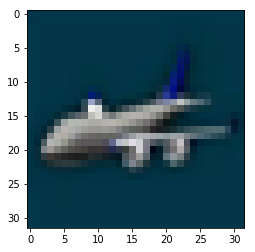

In [67]:
plt.imshow(image_loader(test_image, image_size))

In [7]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
#fig = plt.plot(run_before, run_after, 'ro-')
#fig = plt.plot(walk_before, walk_after, 'bo-')
colums = 10
rows = 5
for i in range(1, colums*rows+1):
    try:
        image = image_loader(train_image_paths[result_ids[i]], image_size)
        fig.add_subplot(rows, colums, i)
        plt.imshow(image)
    except:
        pass
plt.show()

<Figure size 1152x1152 with 0 Axes>

In [8]:
chans = cv2.split(X_train[0])
features = []
for chan in chans:
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.append(hist)
    
    plt.plot(hist)
    plt.xlim([0, 256])

NameError: name 'X_train' is not defined

In [70]:
np.array(features).shape


(3, 256, 1)

In [71]:
np.vstack(features).squeeze()

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  4.,  2.,
        0.,  1.,  1.,  0.,  2.,  0.,  2.,  2.,  0.,  0.,  1.,  3.,  2.,
        1.,  2.,  2.,  3.,  0.,  1.,  2.,  3.,  0.,  3.,  3.,  1.,  2.,
        1.,  2.,  3.,  1.,  1.,  3.,  5.,  0.,  2.,  2.,  6.,  2.,  4.,
        1.,  1.,  2.,  2.,  1.,  4.,  5.,  4.,  1.,  4.,  6.,  5.,  4.,
        1.,  9.,  4.,  8., 11.,  6.,  3.,  5.,  8.,  7.,  6.,  4.,  1.,
        7.,  4., 12., 12., 16., 10., 11., 13., 12., 15., 24., 18., 14.,
       22., 20., 16., 19., 14., 23., 25., 18., 15., 23., 17., 14., 14.,
       14., 12., 15., 10., 14., 14., 17.,  8., 14., 11., 12.,  8.,  4.,
        8.,  2.,  5.,  4.,  2.,  7.,  5.,  7.,  0.,  3.,  9.,  1.,  5.,
        3.,  3.,  4.,  3.,  6.,  1.,  6.,  0.,  2.,  1.,  6.,  3